In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data load

In [2]:
try:
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_FULL_2021_Cleaned_Imputed.csv not found.")

Data loaded successfully with 252 rows (days) and 6540 assets.


In [3]:
data.head()

,AAPL,ABBV,ABT,ACN,ADBE,ADP,AMD,AMGN,AMT,ASML,...,GRU,GSCE,GSP,HDLB,HMDCF,HOMU,HWCPZ,HAWLM,HBANP,HFRO-PA
0,125.974464,86.739708,99.687309,238.710358,485.339996,153.288055,92.300003,193.642502,191.466125,477.949158,...,3.5100,17.25,10.920,6.557615,5.1097,0.55,19.842388,15.62887,18.716362,19.115032
1,127.532021,87.636642,100.920723,240.069351,485.690002,152.861603,92.769997,194.582230,192.433868,483.072815,...,3.4950,17.25,11.430,6.720678,5.1097,0.55,19.909050,15.62887,18.716362,19.110727
2,123.239037,86.879608,100.710602,242.694153,466.309998,152.326324,90.330002,199.272491,187.359482,468.600525,...,3.5450,17.25,11.465,7.058459,5.1097,0.55,19.716475,15.62887,18.716362,19.087008
3,127.444374,87.809464,101.688164,244.983932,477.739990,153.188248,95.160004,199.930344,189.635117,479.316132,...,3.4501,17.25,11.490,7.087579,5.1097,0.55,19.894239,15.62887,18.716362,19.116274
4,128.544388,88.270248,101.971436,245.877502,485.100006,155.184143,94.580002,203.749222,193.733017,486.303741,...,3.5650,17.25,11.690,7.081756,5.1097,0.55,19.975708,15.62887,18.716362,19.026497


### Log returns

In [4]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


In [5]:
ANNUALIZATION_FACTOR = 252

daily_metrics = log_returns.agg(['mean', 'std'])

# 1. Аннуализация ожидаемой доходности (mu)
expected_returns = daily_metrics.loc['mean'] * ANNUALIZATION_FACTOR

# 2. Аннуализация риска (sigma)
annual_volatility = daily_metrics.loc['std'] * np.sqrt(ANNUALIZATION_FACTOR)

# Объединяем результаты в один DataFrame
asset_metrics = pd.DataFrame({
    'Expected Return (mu)': expected_returns,
    'Risk (sigma)': annual_volatility
})

# Сортировка для вывода
asset_metrics = asset_metrics.sort_values(by='Risk (sigma)', ascending=True)

print("Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.")
print("\n--- Top 5 lowest risk assets ---")
print(asset_metrics.head())
print("\n--- Bottom 5 highest risk assets ---")
print(asset_metrics.tail())

Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.

--- Top 5 lowest risk assets ---
      Expected Return (mu)  Risk (sigma)
UCIX              0.025199  6.467086e-19
WARM              0.025199  6.467086e-19
VCOR              0.025199  6.467086e-19
WBHC              0.025199  6.467086e-19
MULG              0.025199  6.467086e-19

--- Bottom 5 highest risk assets ---
      Expected Return (mu)  Risk (sigma)
EOSS             -5.658339     14.391406
ELIO             -2.452975     15.135011
SECI              0.931093     18.431838
APPB             -5.661648     18.724938
NDTP             -0.296223     20.401293


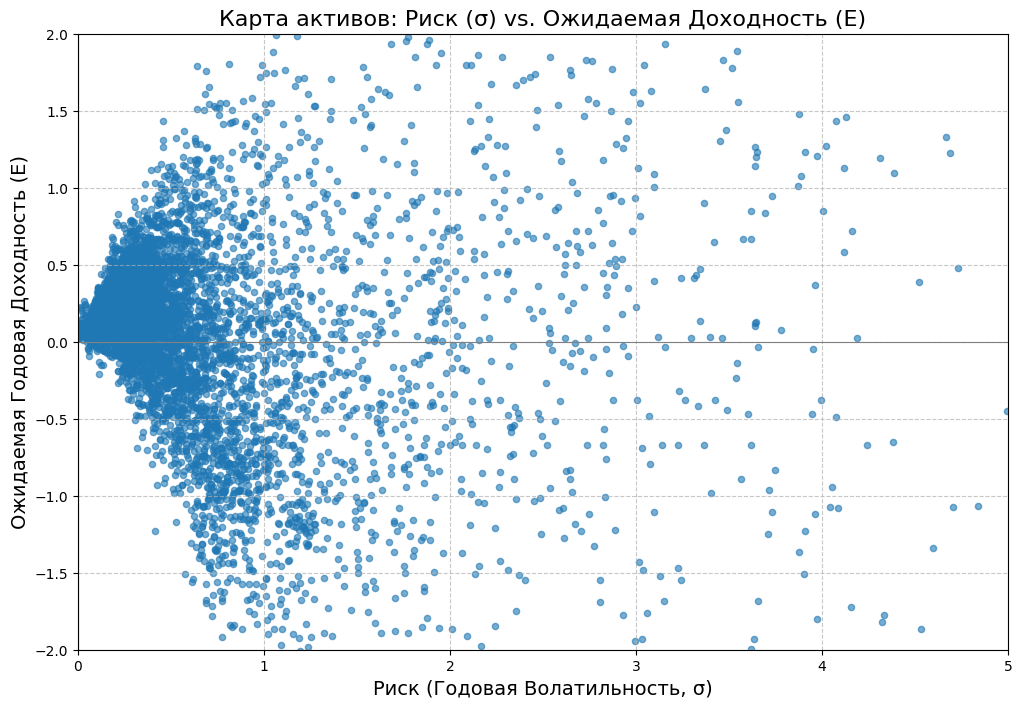

In [6]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.6,
    s=20
)

plt.title('Карта активов: Риск (σ) vs. Ожидаемая Доходность (E)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 5)
plt.ylim(-2, 2)

plt.axhline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевой доходности
plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевого риска

plt.show()

### Поиск Парето-оптимальных активов

In [7]:
df = asset_metrics.reset_index().rename(columns={'index': 'Ticker'})
df_sorted = df.sort_values(by='Risk (sigma)', ascending=True).reset_index(drop=True)

pareto_assets = []
max_return_so_far = -np.inf

for index, row in df_sorted.iterrows():
    current_return = row['Expected Return (mu)']

    # Актив Парето-оптимален, если его доходность строго выше
    # максимальной доходности, достигнутой при меньшем риске.
    if current_return > max_return_so_far:
        pareto_assets.append(row['Ticker'])
        max_return_so_far = current_return

# 3. Фильтрация DataFrame по Парето-оптимальным активам
pareto_df = asset_metrics.loc[pareto_assets]

print(f"\nTotal number of Pareto-Optimal Assets found: {len(pareto_assets)}")
print("\n--- Pareto-Optimal Assets (E, σ) ---")
print(pareto_df.head(10))


Total number of Pareto-Optimal Assets found: 32

--- Pareto-Optimal Assets (E, σ) ---
       Expected Return (mu)  Risk (sigma)
UCIX               0.025199  6.467086e-19
XPTFX              0.043246  6.098673e-03
CCLFX              0.123407  9.506756e-03
NICHX              0.141159  1.149543e-02
PRDEX              0.223496  1.292281e-02
FROPX              0.267259  3.546448e-02
RSF                0.281760  9.812526e-02
PIIVX              0.322518  1.052297e-01
NRSZX              0.352706  1.055189e-01
CET                0.442299  1.216275e-01


Визуализируем Парето-оптимальные активы:

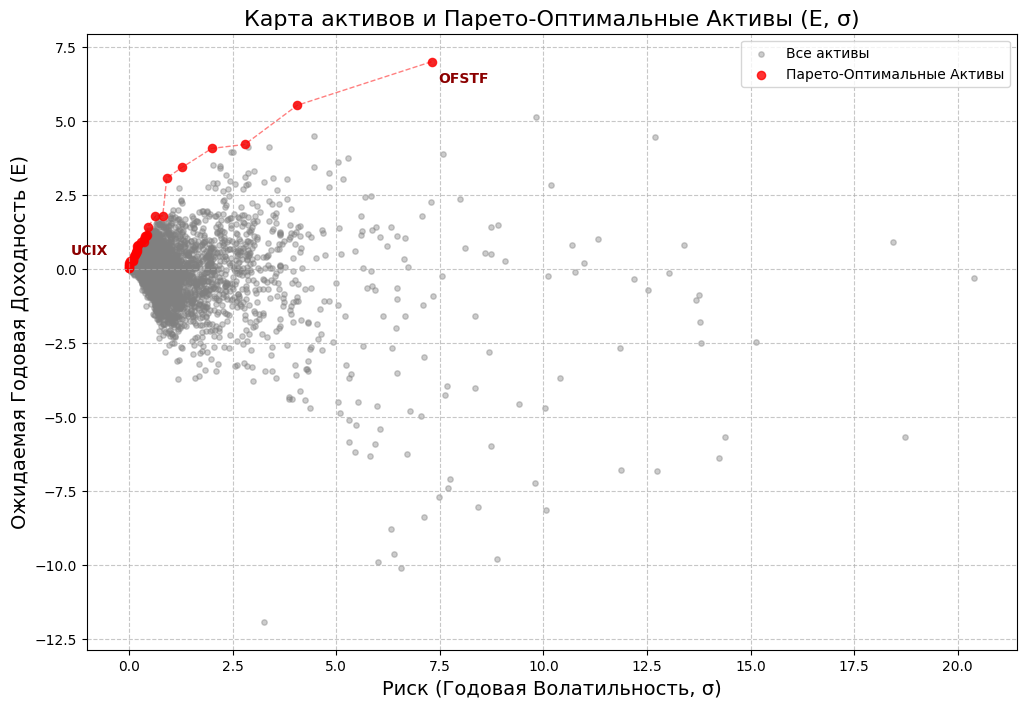

In [8]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

min_risk_asset = pareto_df.iloc[0]
max_return_asset = pareto_df.sort_values(by='Expected Return (mu)', ascending=False).iloc[0]

plt.annotate(
    min_risk_asset.name,
    (min_risk_asset['Risk (sigma)'], min_risk_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(-15, 10),
    ha='right',
    color='darkred',
    fontweight='bold'
)
plt.annotate(
    max_return_asset.name,
    (max_return_asset['Risk (sigma)'], max_return_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, -15),
    ha='left',
    color='darkred',
    fontweight='bold'
)


plt.title('Карта активов и Парето-Оптимальные Активы (E, σ)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Оценка VAR

In [9]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # Уровень значимости
PERCENTILE = ALPHA * 100 # перцентиль для поиска в распределении доходностей (5-й перцентиль)

pareto_log_returns = log_returns[pareto_assets]
var_daily_return = pareto_log_returns.quantile(ALPHA, axis=0)

# VaR - это ожидаемые потери (положительное число), поэтому берем отрицательное значение от доходности.
var_daily = -var_daily_return

# VaR_annual = VaR_daily * sqrt(T), как и стандартное отклонение
ANNUALIZATION_FACTOR = 252
var_annual = var_daily * np.sqrt(ANNUALIZATION_FACTOR)


# Объединяем VaR с метриками риска и доходности
pareto_df['VaR (Daily, 95%)'] = var_daily
pareto_df['VaR (Annual, 95%)'] = var_annual

pareto_df_sorted = pareto_df.sort_values(by='VaR (Annual, 95%)', ascending=True)

print(f"Calculated VaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual VaR ---")
print(pareto_df_sorted.head(10))

Calculated VaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual VaR ---
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  VaR (Annual, 95%)
UCIX               0.025199  6.467086e-19         -0.000100          -0.001587
XPTFX              0.043246  6.098673e-03         -0.000100          -0.001587
CCLFX              0.123407  9.506756e-03         -0.000100          -0.001587
NICHX              0.141159  1.149543e-02         -0.000100          -0.001587
PRDEX              0.223496  1.292281e-02         -0.000100          -0.001587
FROPX              0.267259  3.546448e-02          0.001248           0.019817
PIIVX              0.322518  1.052297e-01          0.004458           0.070769
RSF                0.281760  9.812526e-02          0.007187           0.114098
NRSZX              0.352706  1.055189e-01          0.008387           0.133140
LTAFX              0.539107  1.641799e-01          0.008888           0.141099


In [10]:
# Наиболее предпочтительный актив по VaR - это актив с минимальным VaR.
# pareto_df_sorted уже отсортирован по возрастанию 'VaR (Annual, 95%)' (из cell 9),
# поэтому первый актив - наиболее предпочтительный.
most_preferred_asset = pareto_df_sorted.iloc[0]

ticker = most_preferred_asset.name
risk = most_preferred_asset['Risk (sigma)']
exp_return = most_preferred_asset['Expected Return (mu)']
daily_var = most_preferred_asset['VaR (Daily, 95%)']
annual_var = most_preferred_asset['VaR (Annual, 95%)']

print("--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---")
print(f"Тикер: {ticker}")
print(f"Годовой VaR (95%): {annual_var:.4f}")
print(f"Годовой Риск (σ): {risk:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return:.4f}")

# Для поиска на карте активов:
print("\nРасположение на карте (σ, E):")
print(f"Риск (X-координата): {risk:.4f}")
print(f"Доходность (Y-координата): {exp_return:.4f}")

--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---
Тикер: UCIX
Годовой VaR (95%): -0.0016
Годовой Риск (σ): 0.0000
Ожидаемая Годовая Доходность (E): 0.0252

Расположение на карте (σ, E):
Риск (X-координата): 0.0000
Доходность (Y-координата): 0.0252


In [11]:
data["HMDCF"].describe()

count    252.0000
mean       5.1097
std        0.0000
min        5.1097
25%        5.1097
50%        5.1097
75%        5.1097
max        5.1097
Name: HMDCF, dtype: float64

Это малоликвидный актив, цена которого даже не изменилась за целый год

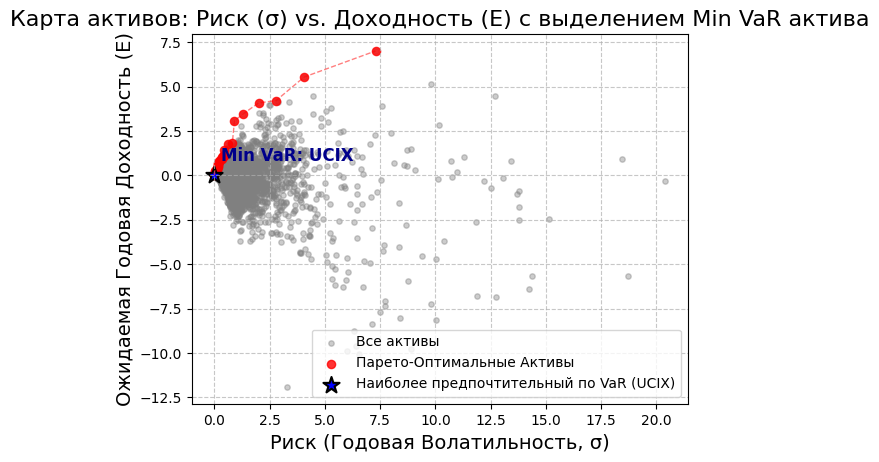

In [12]:
plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

plt.scatter(
    most_preferred_asset['Risk (sigma)'],
    most_preferred_asset['Expected Return (mu)'],
    alpha=1.0,
    s=150,
    color='blue',
    marker='*',
    edgecolors='black',
    linewidths=1.5,
    label=f'Наиболее предпочтительный по VaR ({most_preferred_asset.name})'
)

plt.annotate(
    f'Min VaR: {most_preferred_asset.name}',
    (most_preferred_asset['Risk (sigma)'], most_preferred_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, 10),
    ha='left',
    color='darkblue',
    fontweight='bold',
    fontsize=12
)


plt.title('Карта активов: Риск (σ) vs. Доходность (E) с выделением Min VaR актива', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### Анализ CVaR

In [13]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # 0.05

pareto_log_returns = log_returns[pareto_assets]

# 2. Находим пороговое значение доходности (5-й перцентиль)
var_threshold = pareto_log_returns.quantile(ALPHA, axis=0)

# 3. Рассчитываем CVaR (Average of returns <= threshold)
cvar_daily = {}
for ticker in pareto_log_returns.columns:
    tail_returns = pareto_log_returns[ticker][pareto_log_returns[ticker] <= var_threshold[ticker]]

    # CVaR = - Среднее значение этих хвостов
    cvar_daily[ticker] = -tail_returns.mean()

cvar_daily_series = pd.Series(cvar_daily)

ANNUALIZATION_FACTOR = 252 # возьмём за год
cvar_annual_series = cvar_daily_series * np.sqrt(ANNUALIZATION_FACTOR)

pareto_df['CVaR (Daily, 95%)'] = cvar_daily_series
pareto_df['CVaR (Annual, 95%)'] = cvar_annual_series

pareto_df_cvar_sorted = pareto_df.sort_values(by='CVaR (Annual, 95%)', ascending=True)

print(f"Calculated CVaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---")
print(pareto_df_cvar_sorted[['Expected Return (mu)', 'Risk (sigma)', 'VaR (Annual, 95%)', 'CVaR (Annual, 95%)']].head(10))

Calculated CVaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---
       Expected Return (mu)  Risk (sigma)  VaR (Annual, 95%)  \
UCIX               0.025199  6.467086e-19          -0.001587   
CCLFX              0.123407  9.506756e-03          -0.001587   
NICHX              0.141159  1.149543e-02          -0.001587   
XPTFX              0.043246  6.098673e-03          -0.001587   
PRDEX              0.223496  1.292281e-02          -0.001587   
FROPX              0.267259  3.546448e-02           0.019817   
PIIVX              0.322518  1.052297e-01           0.070769   
NRSZX              0.352706  1.055189e-01           0.133140   
LTAFX              0.539107  1.641799e-01           0.141099   
RSF                0.281760  9.812526e-02           0.114098   

       CVaR (Annual, 95%)  
UCIX            -0.001587  
CCLFX           -0.001529  
NICHX           -0.000862  
XPTFX           -0.000838  
PRDEX           -0.000656  
FROPX            0.03686

In [14]:
# Наиболее предпочтительный актив по CVaR - это актив с минимальным CVaR (первый в отсортированном df)
most_preferred_asset_cvar = pareto_df_cvar_sorted.iloc[0]

ticker_cvar = most_preferred_asset_cvar.name
risk_cvar = most_preferred_asset_cvar['Risk (sigma)']
exp_return_cvar = most_preferred_asset_cvar['Expected Return (mu)']
annual_cvar = most_preferred_asset_cvar['CVaR (Annual, 95%)']

print("\n--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---")
print(f"Тикер: {ticker_cvar}")
print(f"Годовой CVaR (95%): {annual_cvar:.4f}")
print(f"Годовой Риск (σ): {risk_cvar:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return_cvar:.4f}")

# Для сравнения с VaR:
most_preferred_asset_var = pareto_df_sorted.iloc[0]

print("\n--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---")
print(f"Тикер, предпочтительный по VaR: {most_preferred_asset_var.name}")
print(f"Тикер, предпочтительный по CVaR: {ticker_cvar}")

if ticker_cvar == most_preferred_asset_var.name:
    print("Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.")
else:
    print("Вывод: Активы, минимизирующие VaR и CVaR, различаются. Это означает, что актив, минимизирующий CVaR, имеет более тонкий 'хвост' (меньше экстремальных потерь) по сравнению с активом, минимизирующим VaR.")


--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---
Тикер: UCIX
Годовой CVaR (95%): -0.0016
Годовой Риск (σ): 0.0000
Ожидаемая Годовая Доходность (E): 0.0252

--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---
Тикер, предпочтительный по VaR: UCIX
Тикер, предпочтительный по CVaR: UCIX
Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.


### Тесты на белый шум

In [15]:
selected_tickers = []

# 1. Технологический гигант - Apple
selected_tickers.append('AAPL')

# 2. Актив с минимальным VaR
min_var_ticker = pareto_df_sorted.index[0]
selected_tickers.append(min_var_ticker)

# 3. Актив с максимальной доходностью из Парето-оптимальных
max_return_ticker = pareto_df.sort_values('Expected Return (mu)', ascending=False).index[0]
if max_return_ticker not in selected_tickers:
    selected_tickers.append(max_return_ticker)

# 4. Еще один известный актив
if 'MSFT' in log_returns.columns and 'MSFT' not in selected_tickers:
    selected_tickers.append('MSFT')
elif 'GOOGL' in log_returns.columns and 'GOOGL' not in selected_tickers:
    selected_tickers.append('GOOGL')
else:
    for ticker in pareto_df.index:
        if ticker not in selected_tickers:
            selected_tickers.append(ticker)
            break

print("Выбранные для анализа активы:")
print("-" * 50)
for i, ticker in enumerate(selected_tickers, 1):
    if ticker in pareto_df.index:
        risk = pareto_df.loc[ticker, 'Risk (sigma)']
        ret = pareto_df.loc[ticker, 'Expected Return (mu)']
        var_daily = pareto_df.loc[ticker, 'VaR (Daily, 95%)'] if 'VaR (Daily, 95%)' in pareto_df.columns else None
        print(f"{i}. {ticker}:")
        print(f"   Риск (σ): {risk:.4f}")
        print(f"   Доходность (E): {ret:.4f}")
        if var_daily is not None:
            print(f"   VaR (дневной, 95%): {var_daily:.4f}")
    else:
        print(f"{i}. {ticker}: (не в Парето-оптимальных)")
    print()

Выбранные для анализа активы:
--------------------------------------------------
1. AAPL: (не в Парето-оптимальных)

2. UCIX:
   Риск (σ): 0.0000
   Доходность (E): 0.0252
   VaR (дневной, 95%): -0.0001

3. OFSTF:
   Риск (σ): 7.3016
   Доходность (E): 7.0137
   VaR (дневной, 95%): 0.1677

4. MSFT: (не в Парето-оптимальных)



РАСШИРЕННЫЙ АНАЛИЗ АКТИВОВ


AAPL:
  Наблюдений: 251
  Среднее: 0.001385
  Медиана: 0.001572
  Стд. откл.: 0.015749
  5% квантиль: -0.025885
  95% квантиль: 0.026572
  Коэф. вариации: 11.3726
  Асимметрия: -0.1295
  Эксцесс: 0.3678
  Shapiro-Wilk p-value: 0.1304
  Ljung-Box p-value (lag 10): 0.6970
  ACF(1): -0.0347
  ACF(5): -0.0970

  ВЫВОДЫ:
  - Признаки 'белого шума': ДА (по Ljung-Box)
  - Нормальность распределения: НЕ отвергается
  - Максимальная доходность: 0.052546
  - Минимальная доходность: -0.042462
  - Размах: 0.095009
  - Дней с ростом: 134 (53.4%)
  - Дней с падением: 117 (46.6%)


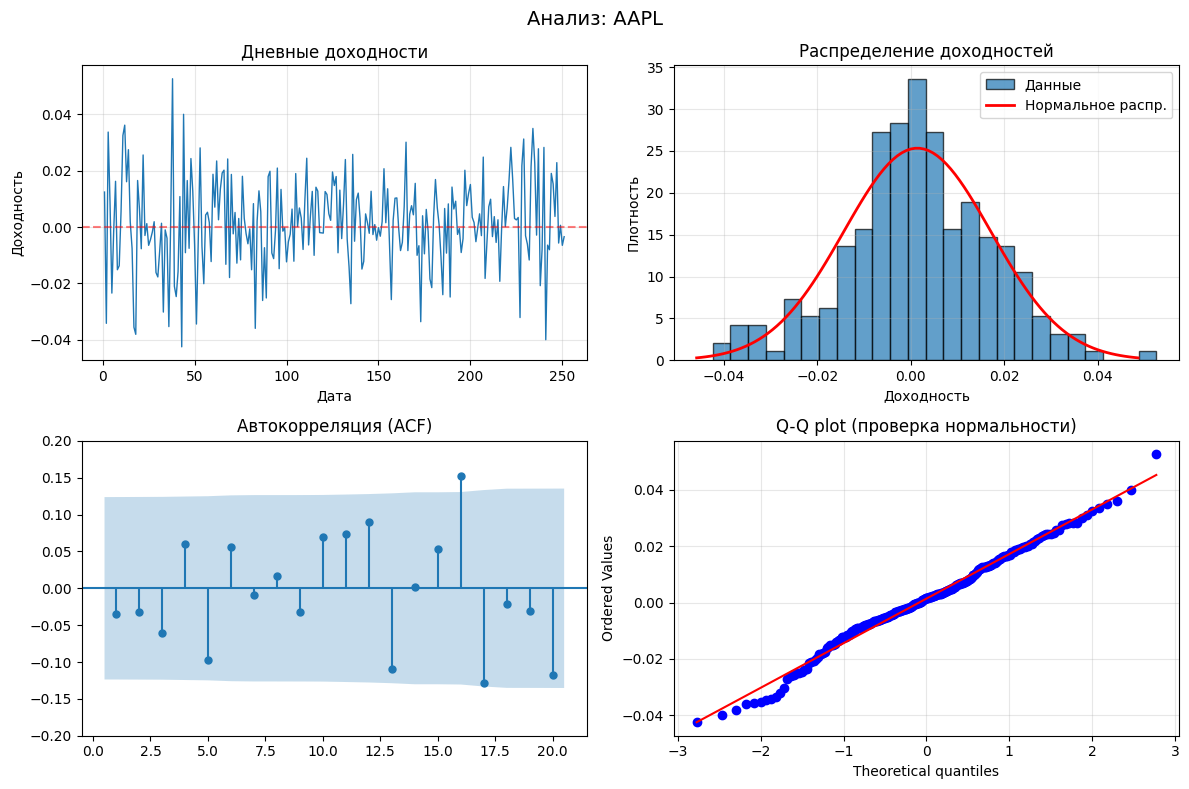



UCIX:
  Наблюдений: 251
  Среднее: 0.000100
  Медиана: 0.000100
  Стд. откл.: 0.000000
  5% квантиль: 0.000100
  95% квантиль: 0.000100
  Коэф. вариации: N/A (малая изменчивость)
  Асимметрия: N/A (малая изменчивость)
  Эксцесс: N/A (малая изменчивость)
  Тест нормальности: N/A (малая изменчивость)
  Ljung-Box p-value (lag 10): 0.0000
  ACF(1): 0.9960
  ACF(5): 0.9801

  ВЫВОДЫ:
  - Признаки 'белого шума': НЕТ
  - Нормальность распределения: невозможно проверить (малая изменчивость)
  - Максимальная доходность: 0.000100
  - Минимальная доходность: 0.000100
  - Размах: 0.000000
  - Дней с ростом: 251 (100.0%)
  - Дней с падением: 0 (0.0%)
  - ВНИМАНИЕ: Данные практически постоянны!


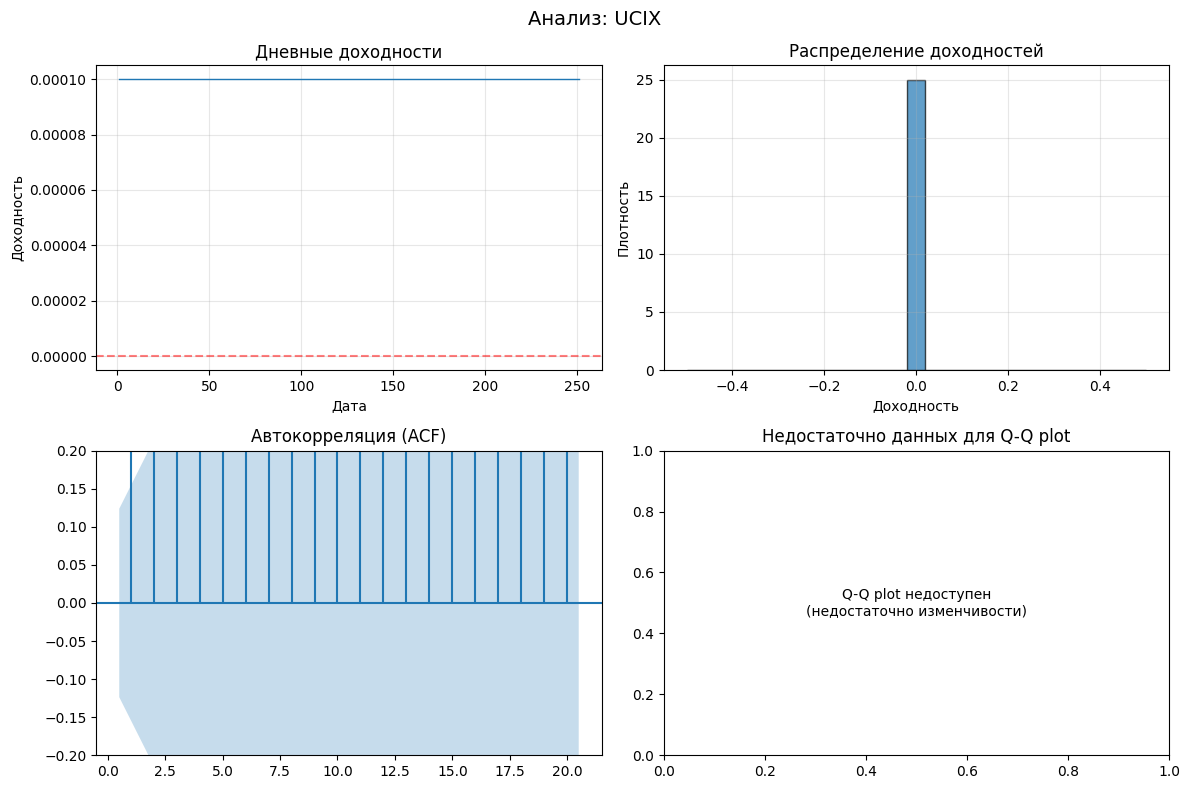



OFSTF:
  Наблюдений: 251
  Среднее: 0.027832
  Медиана: 0.000100
  Стд. откл.: 0.459956
  5% квантиль: -0.167693
  95% квантиль: 0.240029
  Коэф. вариации: 16.5260
  Асимметрия: 3.7497
  Эксцесс: 53.0202
  Shapiro-Wilk p-value: 0.0000
  Ljung-Box p-value (lag 10): 0.0923
  ACF(1): 0.0192
  ACF(5): -0.0009

  ВЫВОДЫ:
  - Признаки 'белого шума': ДА (по Ljung-Box)
  - Нормальность распределения: отвергается
  - Максимальная доходность: 4.605171
  - Минимальная доходность: -2.888573
  - Размах: 7.493745
  - Дней с ростом: 164 (65.3%)
  - Дней с падением: 87 (34.7%)


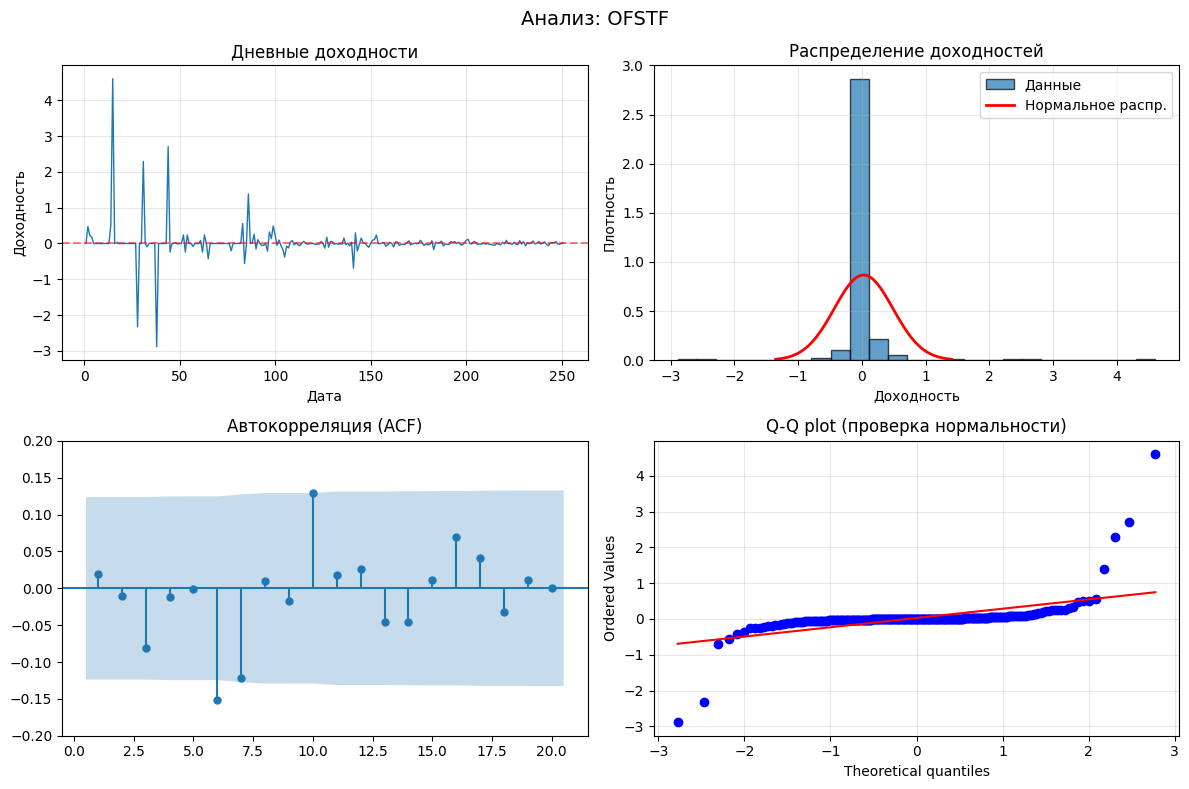



MSFT:
  Наблюдений: 251
  Среднее: 0.001866
  Медиана: 0.001052
  Стд. откл.: 0.013185
  5% квантиль: -0.020934
  95% квантиль: 0.023653
  Коэф. вариации: 7.0653
  Асимметрия: -0.0657
  Эксцесс: 0.3587
  Shapiro-Wilk p-value: 0.0532
  Ljung-Box p-value (lag 10): 0.8963
  ACF(1): -0.0586
  ACF(5): -0.0572

  ВЫВОДЫ:
  - Признаки 'белого шума': ДА (по Ljung-Box)
  - Нормальность распределения: НЕ отвергается
  - Максимальная доходность: 0.041348
  - Минимальная доходность: -0.036771
  - Размах: 0.078119
  - Дней с ростом: 135 (53.8%)
  - Дней с падением: 116 (46.2%)


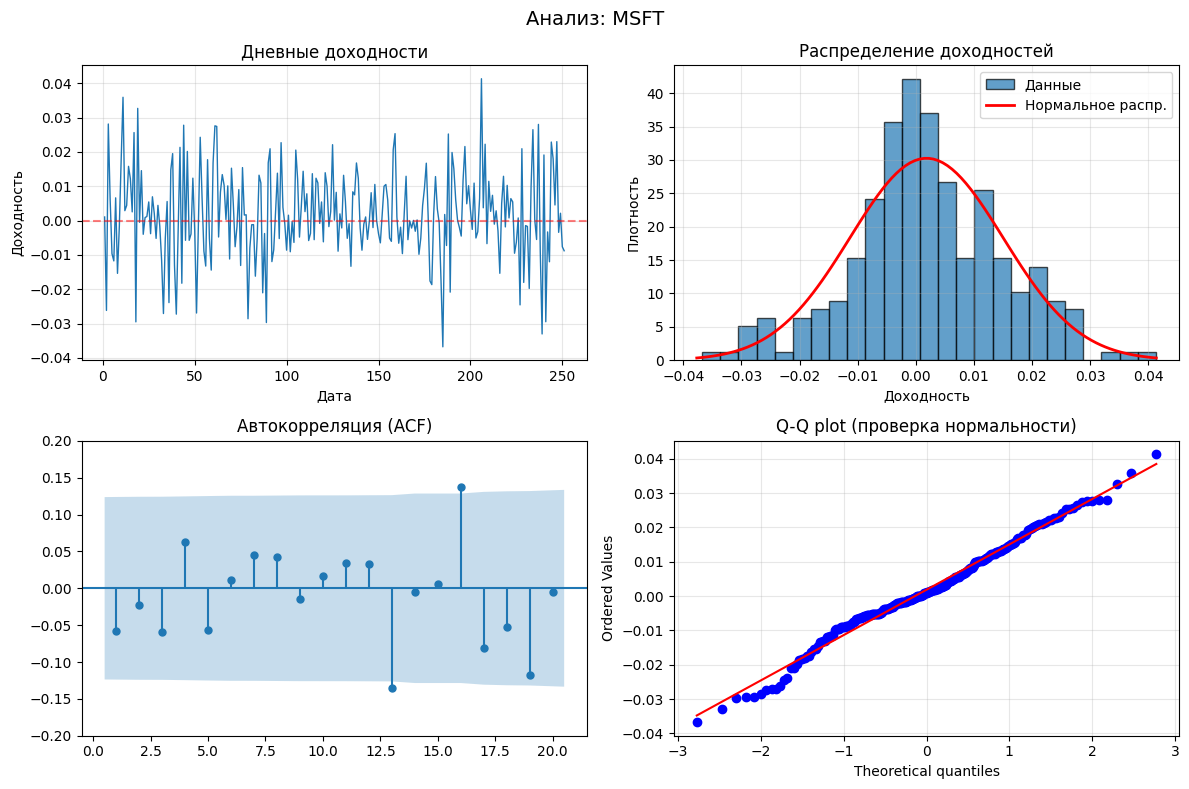


СВОДНАЯ СТАТИСТИКА ПО ВСЕМ АКТИВАМ

Основные статистические показатели:
           mean       std  data_range
AAPL   0.001385  0.015749    0.095009
UCIX   0.000100  0.000000    0.000000
OFSTF  0.027832  0.459956    7.493745
MSFT   0.001866  0.013185    0.078119

Активов с признаками белого шума (p > 0.05): 3 из 4

Среднее количество дней:
  - С ростом: 171.0 (67.9% от года)
  - С падением: 80.0 (31.7% от года)

Топ-3 самых волатильных активов:
  1. OFSTF: std=0.459956, размах=7.493745
  2. AAPL: std=0.015749, размах=0.095009
  3. MSFT: std=0.013185, размах=0.078119

Активов с практическим постоянством (размах < 1e-6): 1
  UCIX

Анализ средних доходностей:
  - С положительной средней доходностью: 4 активов
  - С отрицательной средней доходностью: 0 активов
  - С нулевой средней доходностью: 0 активов

  Топ-4 по средней доходности:
    1. OFSTF: 0.027832
    2. MSFT: 0.001866
    3. AAPL: 0.001385
    4. UCIX: 0.000100

Анализ асимметрии распределения:
  - Правосторонняя асимметрия (>0

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox






def simple_analysis(ticker, returns_series):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f'Анализ: {ticker}', fontsize=14)
    
    # Проверяем, достаточно ли изменчивости в данных
    data_range = returns_series.max() - returns_series.min()
    is_constant_data = data_range < 1e-10  # Практически постоянные данные
    
    # 1. График доходностей
    axes[0, 0].plot(returns_series.index, returns_series.values, linewidth=1)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[0, 0].set_title('Дневные доходности')
    axes[0, 0].set_xlabel('Дата')
    axes[0, 0].set_ylabel('Доходность')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Гистограмма с нормальным распределением
    mu, std = returns_series.mean(), returns_series.std()
    axes[0, 1].hist(returns_series, bins=25, density=True, 
                    edgecolor='black', alpha=0.7, label='Данные')
    
    # Добавляем кривую нормального распределения только если есть изменчивость
    if not is_constant_data and std > 0:
        x = np.linspace(mu - 3*std, mu + 3*std, 100)
        y = stats.norm.pdf(x, mu, std)
        axes[0, 1].plot(x, y, 'r-', linewidth=2, label='Нормальное распр.')
    
    axes[0, 1].set_title('Распределение доходностей')
    axes[0, 1].set_xlabel('Доходность')
    axes[0, 1].set_ylabel('Плотность')
    if not is_constant_data and std > 0:
        axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. ACF
    try:
        plot_acf(returns_series, lags=20, alpha=0.05, ax=axes[1, 0], zero=False)
        axes[1, 0].set_title('Автокорреляция (ACF)')
        axes[1, 0].set_ylim(-0.2, 0.2)
    except Exception as e:
        axes[1, 0].text(0.5, 0.5, f'ACF не доступна\n{str(e)}', 
                       ha='center', va='center', transform=axes[1, 0].transAxes)
    
    # 4. Q-Q plot для проверки нормальности (только если есть изменчивость)
    if not is_constant_data and data_range > 0:
        try:
            stats.probplot(returns_series, dist="norm", plot=axes[1, 1])
            axes[1, 1].set_title('Q-Q plot (проверка нормальности)')
            axes[1, 1].grid(True, alpha=0.3)
        except Exception as e:
            # Запасной вариант
            axes[1, 1].scatter(returns_series[:-1], returns_series[1:], alpha=0.5, s=10)
            axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
            axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
            axes[1, 1].set_title('Доходность(t) vs Доходность(t-1)')
            axes[1, 1].set_xlabel('Доходность(t-1)')
            axes[1, 1].set_ylabel('Доходность(t)')
            axes[1, 1].grid(True, alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Q-Q plot недоступен\n(недостаточно изменчивости)', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Недостаточно данных для Q-Q plot')
    
    plt.tight_layout()
    
    # РАСШИРЕННЫЙ СТАТИСТИЧЕСКИЙ АНАЛИЗ
    print(f"\n{ticker}:")
    print(f"  Наблюдений: {len(returns_series)}")
    print(f"  Среднее: {returns_series.mean():.6f}")
    print(f"  Медиана: {returns_series.median():.6f}")
    print(f"  Стд. откл.: {returns_series.std():.6f}")
    
    # Квантили
    print(f"  5% квантиль: {returns_series.quantile(0.05):.6f}")
    print(f"  95% квантиль: {returns_series.quantile(0.95):.6f}")
    
    # Вычисляем коэффициенты только если есть достаточно изменчивости
    if not is_constant_data and returns_series.std() > 0:
        # Коэффициент вариации
        cv = returns_series.std() / abs(returns_series.mean()) if returns_series.mean() != 0 else float('inf')
        print(f"  Коэф. вариации: {cv:.4f}")
        
        # Асимметрия и эксцесс с защитой от численных проблем
        try:
            skewness = stats.skew(returns_series)
            print(f"  Асимметрия: {skewness:.4f}")
        except Exception as e:
            print(f"  Асимметрия: N/A (ошибка: {str(e)})")
            skewness = None
        
        try:
            kurt = stats.kurtosis(returns_series)
            print(f"  Эксцесс: {kurt:.4f}")
        except Exception as e:
            print(f"  Эксцесс: N/A (ошибка: {str(e)})")
            kurt = None
    else:
        print(f"  Коэф. вариации: N/A (малая изменчивость)")
        print(f"  Асимметрия: N/A (малая изменчивость)")
        print(f"  Эксцесс: N/A (малая изменчивость)")
        skewness = None
        kurt = None
    
    # Проверка на нормальность (только если есть изменчивость)
    normal_test_p = None
    if not is_constant_data and returns_series.std() > 0:
        try:
            if len(returns_series) < 5000:
                shapiro_stat, shapiro_p = stats.shapiro(returns_series)
                print(f"  Shapiro-Wilk p-value: {shapiro_p:.4f}")
                normal_test_p = shapiro_p
            else:
                anderson_result = stats.anderson(returns_series, dist='norm')
                print(f"  Anderson-Darling stat: {anderson_result.statistic:.4f}")
        except Exception as e:
            print(f"  Тест нормальности: N/A ({str(e)})")
    else:
        print(f"  Тест нормальности: N/A (малая изменчивость)")
    
    # Тест Ljung-Box
    try:
        lb_test = acorr_ljungbox(returns_series, lags=[10], return_df=True)
        lb_pvalue = lb_test.loc[10, 'lb_pvalue']
        print(f"  Ljung-Box p-value (lag 10): {lb_pvalue:.4f}")
    except Exception as e:
        lb_pvalue = None
        print(f"  Ljung-Box: N/A ({str(e)})")
    
    # Дополнительные тесты автокорреляции
    try:
        # Тест на автокорреляцию 1-го порядка
        from statsmodels.tsa.stattools import acf
        acf_values = acf(returns_series, nlags=5, fft=False)
        print(f"  ACF(1): {acf_values[1]:.4f}")
        print(f"  ACF(5): {acf_values[5]:.4f}")
    except:
        print(f"  ACF: N/A")
    
    # Критерии для выводов
    print("\n  ВЫВОДЫ:")
    
    # Проверка на белый шум
    if lb_pvalue and lb_pvalue > 0.05:
        print("  - Признаки 'белого шума': ДА (по Ljung-Box)")
    else:
        print("  - Признаки 'белого шума': НЕТ")
    
    # Проверка нормальности
    if normal_test_p and normal_test_p > 0.05:
        print("  - Нормальность распределения: НЕ отвергается")
    elif normal_test_p:
        print("  - Нормальность распределения: отвергается")
    else:
        print("  - Нормальность распределения: невозможно проверить (малая изменчивость)")
    
    # Анализ волатильности
    print(f"  - Максимальная доходность: {returns_series.max():.6f}")
    print(f"  - Минимальная доходность: {returns_series.min():.6f}")
    print(f"  - Размах: {data_range:.6f}")
    
    # Считаем дни с ростом/падением
    positive_days = (returns_series > 0).sum()
    negative_days = (returns_series < 0).sum()
    zero_days = (returns_series == 0).sum()
    print(f"  - Дней с ростом: {positive_days} ({positive_days/len(returns_series)*100:.1f}%)")
    print(f"  - Дней с падением: {negative_days} ({negative_days/len(returns_series)*100:.1f}%)")
    if zero_days > 0:
        print(f"  - Дней без изменений: {zero_days} ({zero_days/len(returns_series)*100:.1f}%)")
    
    # Проверяем, постоянны ли данные
    if is_constant_data or data_range < 1e-6:
        print("  - ВНИМАНИЕ: Данные практически постоянны!")
    
    return fig, {
        'lb_pvalue': lb_pvalue,
        'mean': returns_series.mean(),
        'std': returns_series.std(),
        'skew': skewness,
        'kurtosis': kurt,
        'data_range': data_range,
        'is_constant': is_constant_data,
        'positive_days': positive_days,
        'negative_days': negative_days,
        'zero_days': zero_days
    }

# Простой анализ для каждого актива
print("РАСШИРЕННЫЙ АНАЛИЗ АКТИВОВ")
print("=" * 70)

results_summary = {}

for ticker in selected_tickers:
    if ticker in log_returns.columns:
        returns = log_returns[ticker].dropna()
        if len(returns) > 30:
            print(f"\n{'='*70}")
            fig, stats_dict = simple_analysis(ticker, returns)
            results_summary[ticker] = stats_dict
            plt.show()



# Сводная статистика по всем проанализированным активам
if results_summary:
    print(f"\n{'='*70}")
    print("СВОДНАЯ СТАТИСТИКА ПО ВСЕМ АКТИВАМ")
    print("=" * 70)
    
    # Создаем DataFrame для сводной статистики
    summary_df = pd.DataFrame(results_summary).T
    
    # КОНВЕРТИРУЕМ ЧИСЛОВЫЕ КОЛОНКИ В ПРАВИЛЬНЫЕ ТИПЫ
    numeric_columns = ['mean', 'std', 'data_range', 'lb_pvalue', 'skew', 'kurtosis', 
                      'positive_days', 'negative_days', 'zero_days']
    
    for col in numeric_columns:
        if col in summary_df.columns:
            # Конвертируем в numeric, ошибки -> NaN
            summary_df[col] = pd.to_numeric(summary_df[col], errors='coerce')
    
    # Показать основные статистики
    print("\nОсновные статистические показатели:")
    print(summary_df[['mean', 'std', 'data_range']].round(6))
    
    # Анализ белого шума
    if 'lb_pvalue' in summary_df.columns:
        white_noise_count = summary_df['lb_pvalue'].apply(lambda x: x > 0.05 if pd.notnull(x) else False).sum()
        print(f"\nАктивов с признаками белого шума (p > 0.05): {white_noise_count} из {len(summary_df)}")
    
    # Анализ дней роста/падения
    if 'positive_days' in summary_df.columns:
        avg_positive = summary_df['positive_days'].mean()
        avg_negative = summary_df['negative_days'].mean()
        print(f"\nСреднее количество дней:")
        print(f"  - С ростом: {avg_positive:.1f} ({avg_positive/252*100:.1f}% от года)")
        print(f"  - С падением: {avg_negative:.1f} ({avg_negative/252*100:.1f}% от года)")
    
    # Анализ волатильности
    if 'std' in summary_df.columns:
        # Фильтруем активы с достаточной изменчивостью
        volatile_assets = summary_df[summary_df['data_range'] > 1e-6]
        
        if len(volatile_assets) > 0:
            # Найти самые волатильные
            # Сортируем вручную, так как после конвертации типы должны быть правильными
            volatile_assets = volatile_assets.sort_values('std', ascending=False)
            top_n = min(5, len(volatile_assets))
            top_volatile = volatile_assets.head(top_n)
            
            print(f"\nТоп-{top_n} самых волатильных активов:")
            for idx, (ticker, row) in enumerate(top_volatile.iterrows(), 1):
                print(f"  {idx}. {ticker}: std={row['std']:.6f}, размах={row['data_range']:.6f}")
        
        # Найти наименее волатильные (практически постоянные)
        constant_assets = summary_df[summary_df['data_range'] < 1e-6]
        if len(constant_assets) > 0:
            print(f"\nАктивов с практическим постоянством (размах < 1e-6): {len(constant_assets)}")
            if len(constant_assets) <= 10:  # Показать все если их немного
                print("  " + ", ".join(constant_assets.index.tolist()))
            else:
                print(f"  Первые 10: {', '.join(constant_assets.index.tolist()[:10])}")
    
    # Анализ средних доходностей
    if 'mean' in summary_df.columns:
        positive_mean = summary_df[summary_df['mean'] > 0]
        negative_mean = summary_df[summary_df['mean'] < 0]
        zero_mean = summary_df[abs(summary_df['mean']) < 1e-8]
        
        print(f"\nАнализ средних доходностей:")
        print(f"  - С положительной средней доходностью: {len(positive_mean)} активов")
        print(f"  - С отрицательной средней доходностью: {len(negative_mean)} активов")
        print(f"  - С нулевой средней доходностью: {len(zero_mean)} активов")
        
        # Топ-5 по средней доходности
        if len(positive_mean) > 0:
            positive_mean = positive_mean.sort_values('mean', ascending=False)
            top_n = min(5, len(positive_mean))
            top_returns = positive_mean.head(top_n)
            
            print(f"\n  Топ-{top_n} по средней доходности:")
            for idx, (ticker, row) in enumerate(top_returns.iterrows(), 1):
                print(f"    {idx}. {ticker}: {row['mean']:.6f}")
        
        # Топ-5 по отрицательной доходности (самые убыточные)
        if len(negative_mean) > 0:
            negative_mean = negative_mean.sort_values('mean', ascending=True)
            top_n = min(5, len(negative_mean))
            bottom_returns = negative_mean.head(top_n)
            
            print(f"\n  Топ-{top_n} по отрицательной доходности:")
            for idx, (ticker, row) in enumerate(bottom_returns.iterrows(), 1):
                print(f"    {idx}. {ticker}: {row['mean']:.6f}")
    
    # Анализ асимметрии (если доступно)
    if 'skew' in summary_df.columns:
        skew_data = summary_df['skew'].dropna()
        if len(skew_data) > 0:
            right_skew = len(skew_data[skew_data > 0.1])
            left_skew = len(skew_data[skew_data < -0.1])
            symmetric = len(skew_data) - right_skew - left_skew
            
            print(f"\nАнализ асимметрии распределения:")
            print(f"  - Правосторонняя асимметрия (>0.1): {right_skew} активов")
            print(f"  - Левосторонняя асимметрия (<-0.1): {left_skew} активов")
            print(f"  - Симметричное распределение: {symmetric} активов")
            
            # Примеры активов с разными типами асимметрии
            if right_skew > 0:
                right_examples = skew_data[skew_data > 0.1].nlargest(3)
                print(f"  Примеры правосторонней асимметрии: {', '.join(right_examples.index.tolist())}")
    
    # Общая сводка
    print(f"\n{'='*70}")
    print("АНАЛИЗ ЗАВЕРШЕН")
    print(f"Всего проанализировано активов: {len(summary_df)}")
    
    # Дополнительные метрики
    if 'std' in summary_df.columns:
        print(f"Среднее стандартное отклонение: {summary_df['std'].mean():.6f}")
        print(f"Медианное стандартное отклонение: {summary_df['std'].median():.6f}")
    
    if 'mean' in summary_df.columns:
        print(f"Средняя доходность: {summary_df['mean'].mean():.6f}")
        print(f"Медианная доходность: {summary_df['mean'].median():.6f}")

### Тесты на нормальное распределение

In [17]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

def test_normality(r, name="TICKER"):
    r = r.dropna()
    print("===", name, "n=", len(r), "mean=", r.mean(), "std=", r.std())
    # Histogram + KDE + Normal pdf
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(r, kde=True, stat='density', ax=ax[0])
    xs = np.linspace(r.min(), r.max(), 200)
    ax[0].plot(xs, stats.norm.pdf(xs, r.mean(), r.std()), label='Normal fit')
    ax[0].legend()

    # Q-Q plot
    sm.qqplot(r, line='s', ax=ax[1])
    ax[1].set_title(f"QQ {name}")
    plt.show()

    # Tests
    jb_stat, jb_p = stats.jarque_bera(r)
    sh_stat, sh_p = stats.shapiro(r)
    ad_res = stats.anderson(r, dist='norm')
    ks_stat, ks_p = stats.kstest((r - r.mean())/r.std(), 'norm')
    print("Jarque-Bera:", jb_stat, jb_p)
    print("Shapiro-Wilk:", sh_stat, sh_p)
    print("KS (std sample vs N(0,1)):", ks_stat, ks_p)

Для анализа выберем 4 компании:
1) Apple Inc. (AAPL). Производственный сектор: Information Technology
2) Coca-Cola Europacific Partners PLC (CCEP) Производственный сектор: Consumer Staples
3) Tesla, Inc. (TSLA) Производственный сектор: Consumer Discretionary
4) Biogen Inc. (BIIB) Производственный сектор: Health Care

=== AAPL n= 251 mean= 0.0013848389582081864 std= 0.015749152378848053


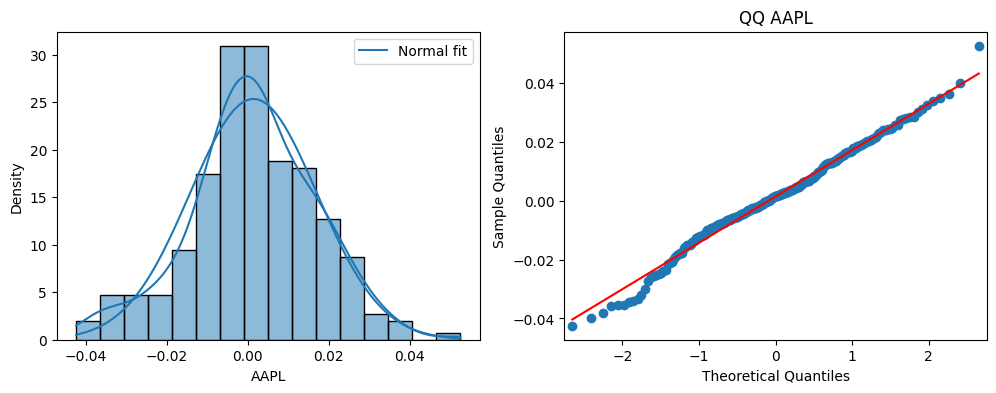

Jarque-Bera: 2.115819093004171 0.3471808176236278
Shapiro-Wilk: 0.9910913081312065 0.13037136862720605
KS (std sample vs N(0,1)): 0.05444394753257081 0.43123273761761993


In [18]:
test_normality(log_returns['AAPL'], 'AAPL')

1) Jarque-Bera: p > 0.05 -> нет значимых отклонений от нормальности
2) Shapiro-Wilk: p > 0.05 -> нормальность не отвергается
3) Kolmogorov–Smirnov (KS-test): p > 0.05 -> нормальность не отвергается

  Отсюда делаем вывод, что для доходность акций компании AAPL подчиняется нормальному закону

=== CCEP n= 251 mean= 0.0007939548002267296 std= 0.016674939054910923


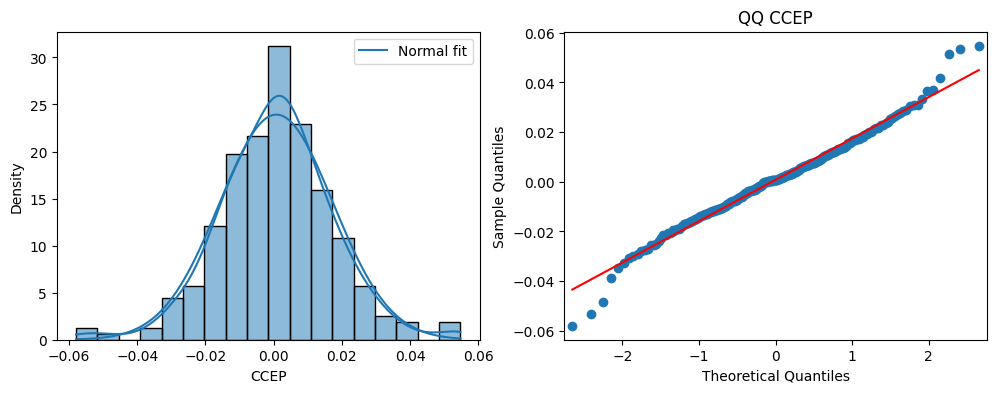

Jarque-Bera: 16.049968932096945 0.0003271851085465335
Shapiro-Wilk: 0.9860427308734154 0.015025123391040812
KS (std sample vs N(0,1)): 0.03945942158755672 0.8144029420605642


In [19]:
test_normality(log_returns['CCEP'], 'CCEP')

1) Jarque-Bera: p < 0.05 -> гипотеза о нормальности отвергается
2) Shapiro-Wilk: p < 0.05 -> гипотеза о нормальности отвергается
3) Kolmogorov–Smirnov (KS-test): p > 0.05 -> нормальность не отвергается

  Отсюда делаем вывод, что для доходность акций компании CCEP не подчиняется нормальному закону

=== TSLA n= 251 mean= 0.0015750147124171643 std= 0.03415696172144503


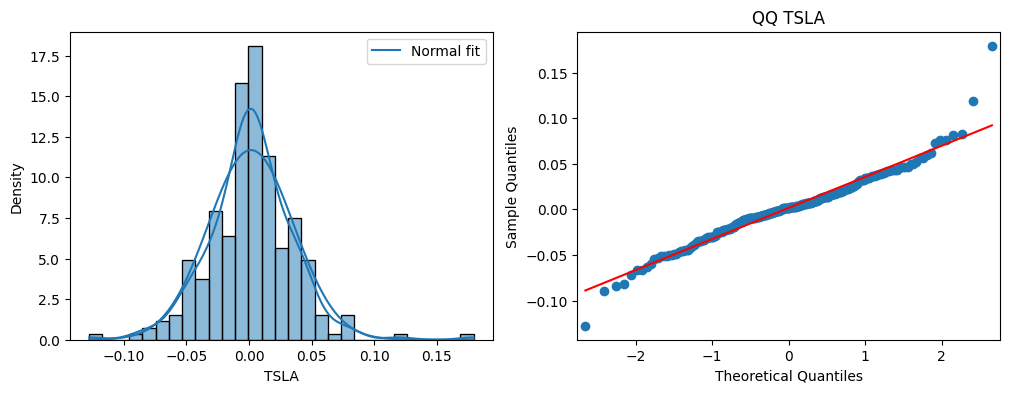

Jarque-Bera: 129.32902402021804 8.252000755134749e-29
Shapiro-Wilk: 0.9618047152295086 3.2092599999028086e-06
KS (std sample vs N(0,1)): 0.07499787349967146 0.11284823045028103


In [20]:
test_normality(log_returns['TSLA'], 'TSLA')

1) Jarque-Bera: p < 0.05 -> гипотеза о нормальности отвергается
2) Shapiro-Wilk: p < 0.05 -> гипотеза о нормальности отвергается
3) Kolmogorov–Smirnov (KS-test): p < 0.05 -> гипотеза о нормальности отвергается

  Отсюда делаем вывод, что для доходность акций компании TSLA не подчиняется нормальному закону

=== BIIB n= 251 mean= 5.003707044565762e-05 std= 0.02820482859142472


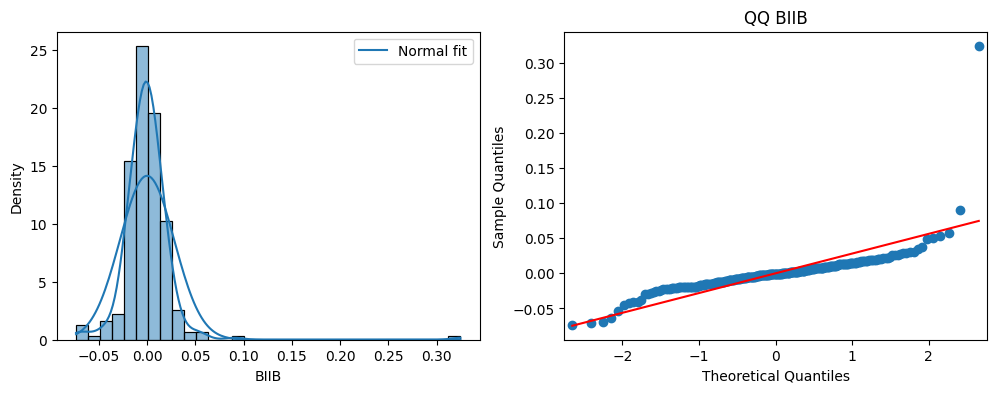

Jarque-Bera: 51193.43610588213 0.0
Shapiro-Wilk: 0.6220116341720445 3.5627470367868284e-23
KS (std sample vs N(0,1)): 0.15361977611012556 1.2262200961043202e-05


In [21]:
test_normality(log_returns['BIIB'], 'BIIB')

1) Jarque-Bera: p < 0.05 -> гипотеза о нормальности отвергается
2) Shapiro-Wilk: p < 0.05 -> гипотеза о нормальности отвергается
3) Kolmogorov–Smirnov (KS-test): p < 0.05 -> гипотеза о нормальности отвергается

  Отсюда делаем вывод, что для доходность акций компании BIIB не подчиняется нормальному закону

Доходности всех активов, кроме AAPL не подчиняются нормальному закону. Поэтому для них проверим другие распределения

### Тесты на другие распределения

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def fit_distributions(r, name="TICKER"):
    """
    Параметры:
        r : pandas.Series или numpy.array
        name : название актива
    """
    r = r.dropna().values
    n = len(r)
    
    distributions = {
        "Normal": stats.norm,
        "StudentT": stats.t,
        "Laplace": stats.laplace,
        "Logistic": stats.logistic,
        "GED": stats.gennorm
    }
    
    results = []
    
    for dist_name, dist in distributions.items():
        params = dist.fit(r)
        logL = np.sum(dist.logpdf(r, *params))
        k = len(params)
        
        AIC = 2*k - 2*logL
        BIC = k*np.log(n) - 2*logL
        
        cdf = lambda x: dist.cdf(x, *params)
        ks_stat, ks_p = stats.kstest(r, cdf)
        
        results.append({
            "Distribution": dist_name,
            "LogL": logL,
            "AIC": AIC,
            "BIC": BIC,
            "KS_p": ks_p,
            "Params": params
        })
        
    df_res = pd.DataFrame(results)
    df_res = df_res.sort_values(by="AIC").reset_index(drop=True)
    
    best = df_res.iloc[0]
    print(f"Best fit by AIC: {best['Distribution']}, AIC={best['AIC']:.2f}, KS p-value={best['KS_p']:.3f}")
    return df_res

In [23]:
fit_distributions(log_returns["CCEP"], name="CCEP")

Best fit by AIC: Logistic, AIC=-1349.61, KS p-value=0.884


,Distribution,LogL,AIC,BIC,KS_p,Params
0,Logistic,676.803495,-1349.606990,-1342.556084,0.884357,"(0.0007697146259237181, 0.009100997243813037)"
1,GED,676.906267,-1347.812535,-1337.236176,0.966989,"(1.3486800602761975, 0.0008348451469548626, 0...."
2,StudentT,676.779440,-1347.558880,-1336.982521,0.886725,"(6.402666465296001, 0.0007677197758722276, 0.0..."
3,Laplace,674.256446,-1344.512893,-1337.461987,0.680195,"(0.000786169902833556, 0.012532527142470714)"
4,Normal,671.903361,-1339.806721,-1332.755816,0.815643,"(0.0007939548002267296, 0.01664168889409971)"


In [24]:
fit_distributions(log_returns["TSLA"], name="TSLA")

Best fit by AIC: Laplace, AIC=-1007.90, KS p-value=0.964


,Distribution,LogL,AIC,BIC,KS_p,Params
0,Laplace,505.950708,-1007.901415,-1000.850509,0.963580,"(0.001868567181598163, 0.02450478065735718)"
1,GED,506.112956,-1006.225912,-995.649553,0.989259,"(1.0735493870465231, 0.0018549645498029611, 0...."
2,StudentT,504.647690,-1003.295380,-992.719021,0.768460,"(4.467061347957104, 0.0014966611675036408, 0.0..."
3,Logistic,503.129486,-1002.258972,-995.208066,0.519765,"(0.001473908745235562, 0.018015762200203997)"
4,Normal,491.921430,-979.842860,-972.791954,0.115377,"(0.0015750147124171643, 0.03408885205901564)"


In [25]:
fit_distributions(log_returns["BIIB"], name="BIIB")

Best fit by AIC: StudentT, AIC=-1284.44, KS p-value=0.964


,Distribution,LogL,AIC,BIC,KS_p,Params
0,StudentT,645.220855,-1284.441710,-1273.865351,0.963837,"(2.781652198658719, -0.0009832320026410043, 0...."
1,GED,637.173928,-1268.347856,-1257.771497,0.793530,"(0.7661471061197971, -0.0007399014063206518, 0..."
2,Laplace,632.575523,-1261.151045,-1254.100140,0.616104,"(-0.001033288430629131, 0.014796444158588185)"
3,Logistic,621.550999,-1239.101998,-1232.051092,0.561155,"(-0.0009615585408567003, 0.010800902433080526)"
4,Normal,539.981211,-1075.962422,-1068.911516,0.000013,"(5.003707044565762e-05, 0.028148587601084102)"


### Необычные явления на рынке

Кластеризация активов по комбинированным метрикам риска и доходности (μ, σ, VaR, CVaR)


Кластеры присвоены. Количество активов в каждом:
Cluster
0    24
2     5
1     2
3     1
Name: count, dtype: int64


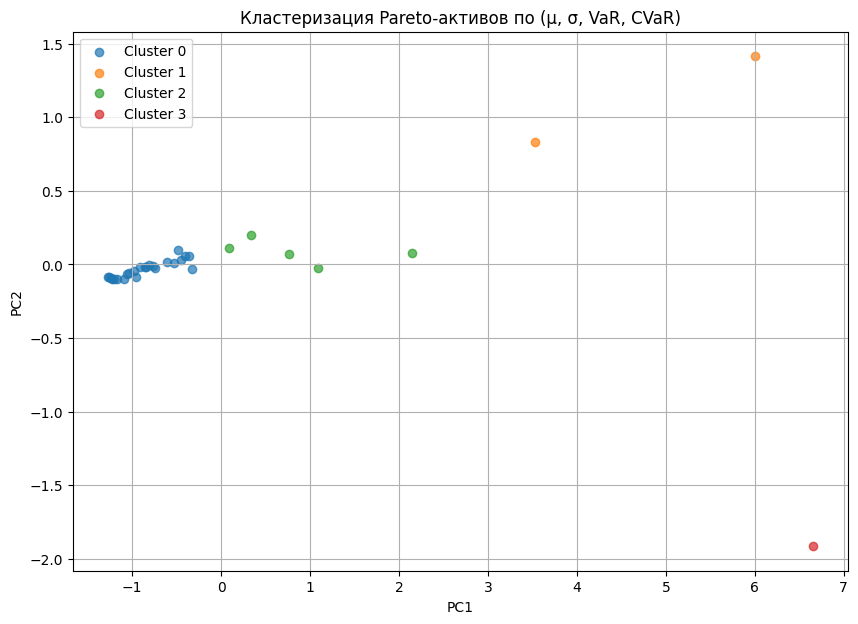


--- Пример активов из каждого кластера ---

Cluster 0:
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  \
UCIX               0.025199  6.467086e-19           -0.0001   
XPTFX              0.043246  6.098673e-03           -0.0001   
CCLFX              0.123407  9.506756e-03           -0.0001   
NICHX              0.141159  1.149543e-02           -0.0001   
PRDEX              0.223496  1.292281e-02           -0.0001   

       VaR (Annual, 95%)  CVaR (Daily, 95%)  CVaR (Annual, 95%)  Cluster  \
UCIX           -0.001587          -0.000100           -0.001587        0   
XPTFX          -0.001587          -0.000053           -0.000838        0   
CCLFX          -0.001587          -0.000096           -0.001529        0   
NICHX          -0.001587          -0.000054           -0.000862        0   
PRDEX          -0.001587          -0.000041           -0.000656        0   

            PC1       PC2  
UCIX  -1.270723 -0.085012  
XPTFX -1.263056 -0.088524  
CCLFX -1.237924 -0.09465

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- 1. Собираем признаки для кластеризации ---
features = pareto_df[['Expected Return (mu)', 
                      'Risk (sigma)', 
                      'VaR (Annual, 95%)', 
                      'CVaR (Annual, 95%)']]

# --- 2. Масштабирование ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- 3. KMeans ---
k = 4  # можно менять
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

pareto_df['Cluster'] = clusters

print("\nКластеры присвоены. Количество активов в каждом:")
print(pareto_df['Cluster'].value_counts())

# --- 4. PCA для визуализации ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pareto_df['PC1'] = X_pca[:,0]
pareto_df['PC2'] = X_pca[:,1]

# --- 5. Отображение кластеров ---
plt.figure(figsize=(10,7))
for c in range(k):
    subset = pareto_df[pareto_df['Cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], label=f"Cluster {c}", alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Кластеризация Pareto-активов по (μ, σ, VaR, CVaR)")
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Пример активов из каждого кластера ---")
for c in range(k):
    print(f"\nCluster {c}:")
    print(pareto_df[pareto_df['Cluster']==c].head())

Одна из ключевых метрик для анализа максимальной просадки:

MDD = min( P_t / max(P_0..t) - 1 )

Хорошо выявляет “опасные” активы.

In [27]:
# --- Maximum Drawdown (MDD) ---

def calculate_mdd(series):
    """
    series: pd.Series of prices for one ticker.
    Returns: maximum drawdown (negative value).
    """
    running_max = series.cummax()
    drawdowns = series / running_max - 1
    return drawdowns.min()  # минимальное значение (самая глубокая просадка)

# Рассчитаем MDD для всех активов
mdd_values = {}

for ticker in data.columns:
    mdd_values[ticker] = calculate_mdd(data[ticker])

mdd_series = pd.Series(mdd_values, name="MDD")

# Добавляем в таблицу всех метрик
asset_metrics['MDD'] = mdd_series

print("\n--- Топ-10 активов с НАИМЕНЬШЕЙ просадкой (лучшие) ---")
print(asset_metrics.sort_values('MDD', ascending=False).head(10))

print("\n--- Топ-10 активов с НАИБОЛЬШЕЙ просадкой (худшие) ---")
print(asset_metrics.sort_values('MDD').head(10))


--- Топ-10 активов с НАИМЕНЬШЕЙ просадкой (лучшие) ---
       Expected Return (mu)  Risk (sigma)  MDD
UCIX               0.025199  6.467086e-19  0.0
ARCXF              3.305763  3.007436e+00  0.0
CITY               0.025199  6.467086e-19  0.0
WEWA               0.025199  6.467086e-19  0.0
MULG               0.025199  6.467086e-19  0.0
ELLKF              0.025199  6.467086e-19  0.0
DSLVF              0.025199  6.467086e-19  0.0
KWIK               0.025199  6.467086e-19  0.0
HMDCF              0.025199  6.467086e-19  0.0
ALPC               0.025199  6.467086e-19  0.0

--- Топ-10 активов с НАИБОЛЬШЕЙ просадкой (худшие) ---
       Expected Return (mu)  Risk (sigma)       MDD
EOSS              -5.658339     14.391406 -1.000000
RNVA             -11.918589      3.269723 -0.999998
CNTTQ            -10.090667      6.557804 -0.999989
SPBV              -2.651878     11.857986 -0.999986
WAYS               4.481731     12.703174 -0.999986
NDTP              -0.296223     20.401293 -0.999984
BRRN   

Кластеризация всех активов с учётом риска, доходности и хвостовой зависимости (TDI)

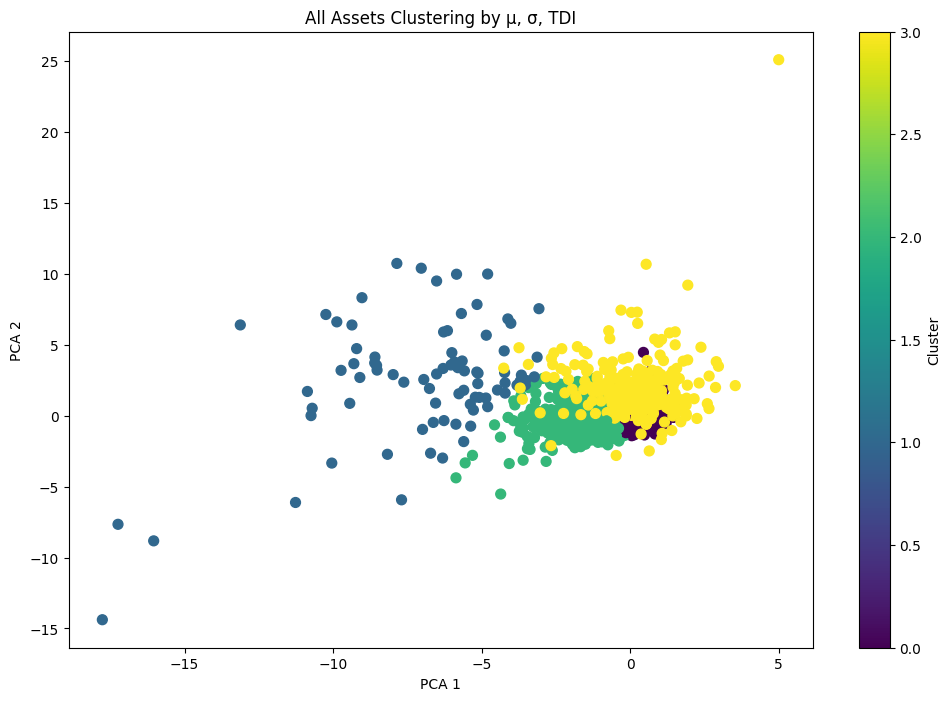


--- Cluster Summary ---
         Expected Return (mu)  Risk (sigma)  TDI (Tail Dependence)
Cluster                                                           
0                    0.223853      0.412948              -0.014178
1                   -4.281032      7.999595              -0.055236
2                   -0.746070      1.285554              -0.048065
3                    1.200970      3.574557               0.015040


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Рыночная доходность (среднее по всем активам)
market_returns = log_returns.mean(axis=1)

# 2. Порог худших 5% дней
threshold = market_returns.quantile(0.05)
tail_days = market_returns <= threshold

# 3. TDI для всех активов
tdi_values = log_returns[tail_days].mean(axis=0)

# 4. Добавляем TDI к asset_metrics
asset_metrics['TDI (Tail Dependence)'] = tdi_values

# 5. Выбираем признаки для кластеризации
features = ['Expected Return (mu)', 'Risk (sigma)', 'TDI (Tail Dependence)']
clustering_data = asset_metrics[features].dropna()

# 6. Нормировка
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# 7. KMeans кластеризация (4 кластера)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

clustering_data['Cluster'] = clusters

# 8. PCA для визуализации
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(scaled_data)

plt.figure(figsize=(12,8))
scatter = plt.scatter(pca_coords[:,0], pca_coords[:,1], c=clusters, cmap='viridis', s=50)
plt.title("All Assets Clustering by μ, σ, TDI")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label='Cluster')
plt.show()

# 9. Сводка по кластерам
cluster_summary = clustering_data.groupby('Cluster')[features].mean()
print("\n--- Cluster Summary ---")
print(cluster_summary)


Cluster 0: 4804 assets
['UCIX', 'WARM', 'VCOR', 'WBHC', 'MULG', 'UGLDF', 'HOVVB', 'ELLKF', 'HLLK', 'ZLME', 'HMDCF', 'ALPC', 'KWIK', 'DSLVF', 'CITY', 'WEWA', 'SCGY', 'XPTFX', 'CCLFX', 'NICHX'] ...

Cluster 1: 82 assets
['RNVA', 'IFMK', 'ATVK', 'CONC', 'DQWS', 'GWIN', 'NUMD', 'CNCN', 'OWCP', 'FCTI', 'GBUX', 'PTCO', 'EWLU', 'PTZH', 'HOMU', 'CLTH', 'MNIZ', 'CXCQ', 'BIIO', 'QIND'] ...

Cluster 2: 1380 assets
['CDRO', 'SFTBY', 'QTWO', 'SFTBF', 'IWML', 'CGNT', 'LVS', 'EGHT', 'SFUNY', 'ASMB', 'JTKWY', 'BABA', 'NOAH', 'PLMR', 'GORO', 'UPLD', 'EMX', 'NRDY', 'LPSN', 'VITL'] ...

Cluster 3: 274 assets
['DXLG', 'LWLG', 'MILC', 'EP', 'IRNS', 'CVAT', 'IVDA', 'DLPN', 'BICX', 'CYCA', 'TNLX', 'CAPC', 'LNDZF', 'KOAN', 'OMWS', 'INCR', 'TRCK', 'WBBA', 'FRTG', 'SBSAA'] ...


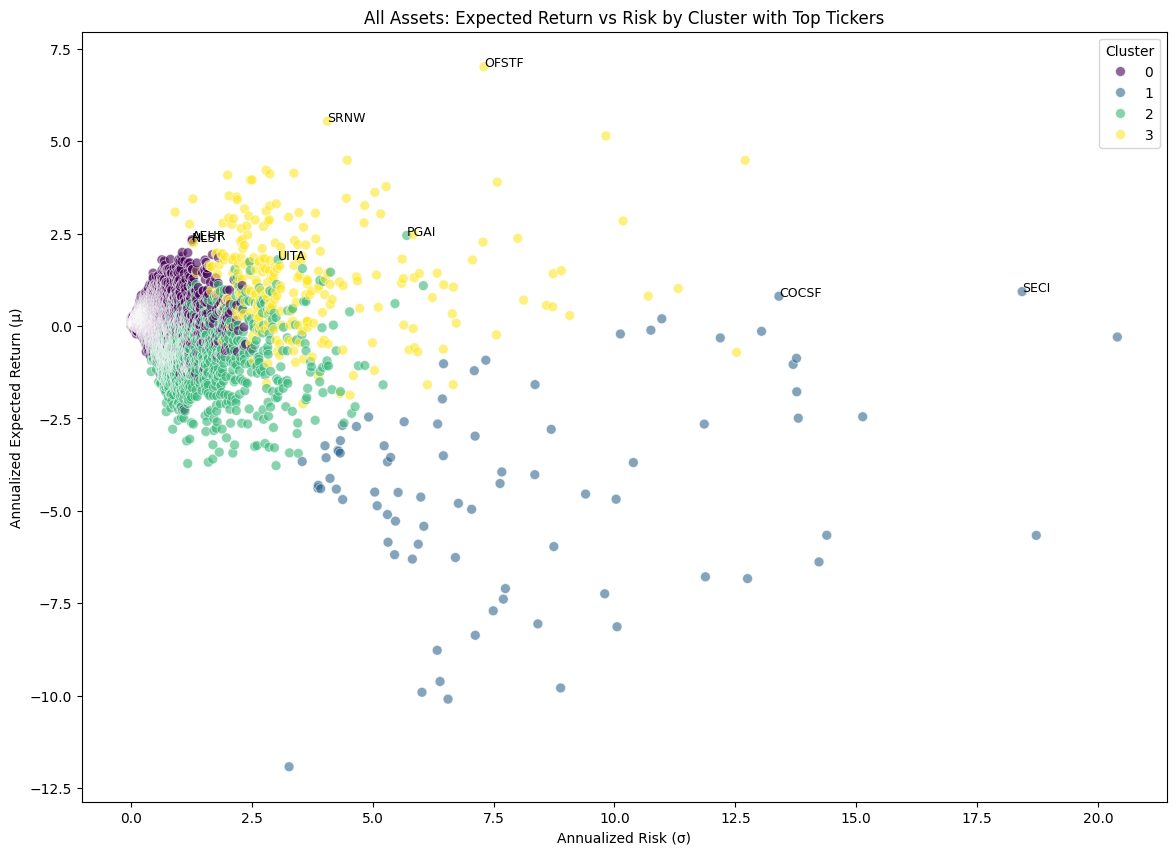

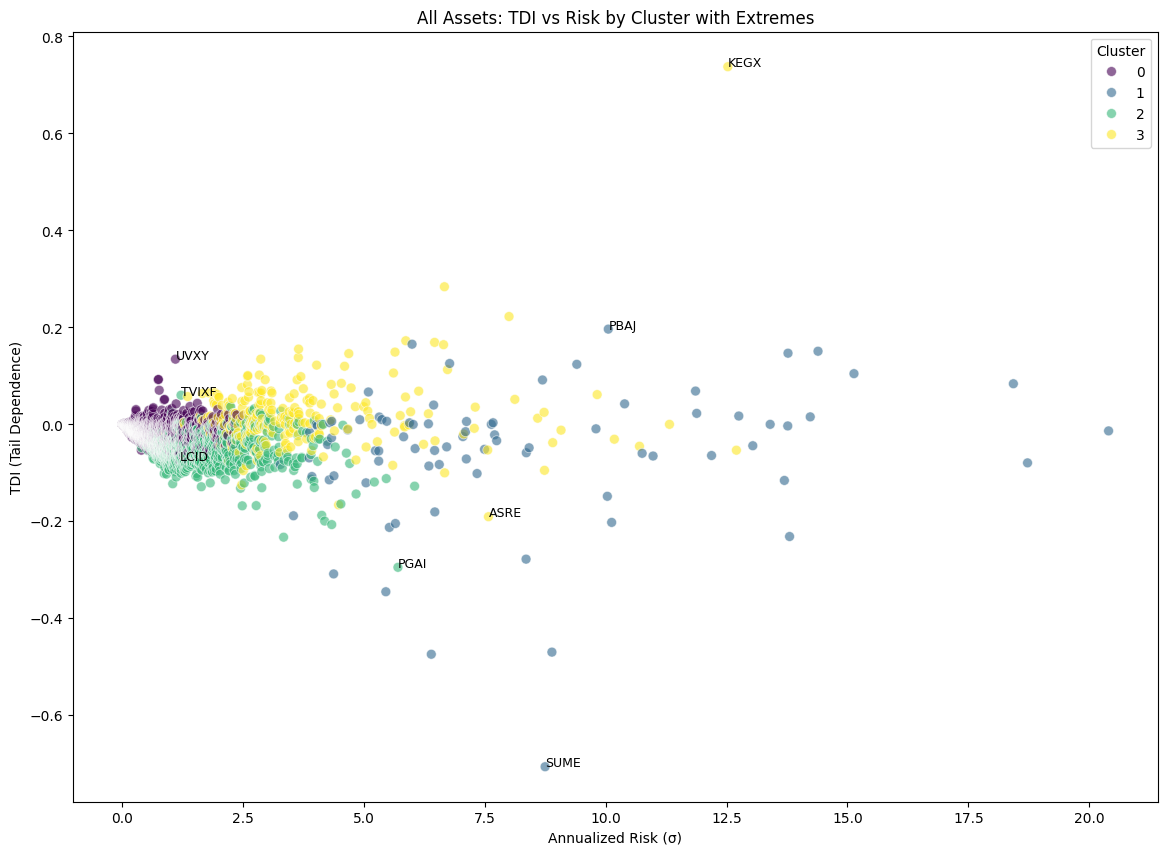

In [29]:
# Добавляем тикеры в clustering_data
clustering_data = clustering_data.copy()
clustering_data['Ticker'] = asset_metrics.index
clustering_data['Cluster'] = clusters

# --- 1. Список активов по кластерам ---
for c in sorted(clustering_data['Cluster'].unique()):
    tickers_in_cluster = clustering_data[clustering_data['Cluster'] == c]['Ticker'].tolist()
    print(f"\nCluster {c}: {len(tickers_in_cluster)} assets")
    print(tickers_in_cluster[:20], '...')  # выводим первые 20 для наглядности

# --- 2. Scatter plot μ vs σ с аннотацией тикеров (топовые по μ в каждом кластере) ---
plt.figure(figsize=(14,10))
sns.scatterplot(x='Risk (sigma)', y='Expected Return (mu)', hue='Cluster', palette='viridis', data=clustering_data, s=50, alpha=0.6)

# Аннотируем топ-2 активов по Expected Return в каждом кластере
for c in clustering_data['Cluster'].unique():
    cluster_df = clustering_data[clustering_data['Cluster'] == c]
    top_assets = cluster_df.nlargest(2, 'Expected Return (mu)')
    for _, row in top_assets.iterrows():
        plt.text(row['Risk (sigma)'], row['Expected Return (mu)'], row['Ticker'], fontsize=9)

plt.title("All Assets: Expected Return vs Risk by Cluster with Top Tickers")
plt.xlabel("Annualized Risk (σ)")
plt.ylabel("Annualized Expected Return (μ)")
plt.legend(title='Cluster')
plt.show()

# --- 3. TDI vs Risk с аннотацией топовых/наименее зависимых активов ---
plt.figure(figsize=(14,10))
sns.scatterplot(x='Risk (sigma)', y='TDI (Tail Dependence)', hue='Cluster', palette='viridis', data=clustering_data, s=50, alpha=0.6)

# Аннотируем топ-1 по TDI и минимальный TDI в каждом кластере
for c in clustering_data['Cluster'].unique():
    cluster_df = clustering_data[clustering_data['Cluster'] == c]
    top_tdi = cluster_df.nlargest(1, 'TDI (Tail Dependence)')
    low_tdi = cluster_df.nsmallest(1, 'TDI (Tail Dependence)')
    for _, row in pd.concat([top_tdi, low_tdi]).iterrows():
        plt.text(row['Risk (sigma)'], row['TDI (Tail Dependence)'], row['Ticker'], fontsize=9)

plt.title("All Assets: TDI vs Risk by Cluster with Extremes")
plt.xlabel("Annualized Risk (σ)")
plt.ylabel("TDI (Tail Dependence)")
plt.legend(title='Cluster')
plt.show()

### Nasdaq100 analysis

Проделаем то же самое, но для более известных компаний из индекса Nasdaq100

In [30]:
try:
    data = pd.read_csv("data/processed/NASDAQ_100_2021_Cleaned.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_100_2021_Cleaned.csv not found.")

Data loaded successfully with 252 rows (days) and 100 assets.


In [31]:
data.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,VRTX,WBA,WBD,WDAY,XEL,ZS,AU10Y,BR10Y,CA10Y,CH10Y
0,"129,41","139,15","485,34","146,02","168,96","296,84","81,54","86,87","92,3","226,66",...,"229,43","41,4","30,63","228,08","65,655","196,09","0,99","6,86","0,677","2,8"
1,"131,01","148,3","485,69","148,63","168,49","301,7","81,43","89,6","92,77","227,76",...,"228,58","41,16","31,52","225,36","65,02","193,48","0,949","6,84","0,713","2,8"
2,"126,6","142,77","466,31","149,3","167,9","302,87","82,08","90,83","90,33","233,25",...,"226,65","43,03","34,25",220,"66,46","184,42","1,061","7,04","0,758","2,81"
3,"130,92","151,27","477,74","155,61","168,85","315,2","79,89","94,56","95,16","234,02",...,"232,9","45,26","34,4","226,21","65,16","193,05","1,058","7,27","0,794","2,83"
4,"132,05","149,77","485,1","156,74","171,05","319,85","79,18","95,56","94,58","238,49",...,237,"45,21","34,63","227,65","65,76","197,37","1,096","7,57","0,815","2,85"


In [32]:
data = data.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18816\3109654890.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: str(x).replace(',', '.') if isinstance(x, str) else x)


In [33]:
data.head()

,AAPL,ABNB,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,...,VRTX,WBA,WBD,WDAY,XEL,ZS,AU10Y,BR10Y,CA10Y,CH10Y
0,129.41,139.15,485.34,146.02,168.96,296.84,81.54,86.87,92.3,226.66,...,229.43,41.4,30.63,228.08,65.655,196.09,0.99,6.86,0.677,2.8
1,131.01,148.3,485.69,148.63,168.49,301.7,81.43,89.6,92.77,227.76,...,228.58,41.16,31.52,225.36,65.02,193.48,0.949,6.84,0.713,2.8
2,126.6,142.77,466.31,149.3,167.9,302.87,82.08,90.83,90.33,233.25,...,226.65,43.03,34.25,220,66.46,184.42,1.061,7.04,0.758,2.81
3,130.92,151.27,477.74,155.61,168.85,315.2,79.89,94.56,95.16,234.02,...,232.9,45.26,34.4,226.21,65.16,193.05,1.058,7.27,0.794,2.83
4,132.05,149.77,485.1,156.74,171.05,319.85,79.18,95.56,94.58,238.49,...,237,45.21,34.63,227.65,65.76,197.37,1.096,7.57,0.815,2.85


In [34]:
data = data.astype(float)

In [35]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


In [36]:
ANNUALIZATION_FACTOR = 252

daily_metrics = log_returns.agg(['mean', 'std'])

expected_returns = daily_metrics.loc['mean'] * ANNUALIZATION_FACTOR
annual_volatility = daily_metrics.loc['std'] * np.sqrt(ANNUALIZATION_FACTOR)
asset_metrics = pd.DataFrame({
    'Expected Return (mu)': expected_returns,
    'Risk (sigma)': annual_volatility
})

asset_metrics = asset_metrics.sort_values(by='Risk (sigma)', ascending=True)

print("Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.")
print("\n--- Top 5 lowest risk assets ---")
print(asset_metrics.head())
print("\n--- Bottom 5 highest risk assets ---")
print(asset_metrics.tail())

Calculated Expected Returns (mu) and Annualized Risk (sigma) for all assets.

--- Top 5 lowest risk assets ---
      Expected Return (mu)  Risk (sigma)
PEP               0.211622      0.145204
MDLZ              0.161003      0.158197
AEP               0.112744      0.165648
KDP               0.180086      0.175725
EXC               0.365102      0.181067

--- Bottom 5 highest risk assets ---
      Expected Return (mu)  Risk (sigma)
MDB               0.439365      0.601486
DASH              0.092917      0.651467
PDD              -1.029932      0.701593
TTD               0.195500      0.707224
MRNA              0.849591      0.803887


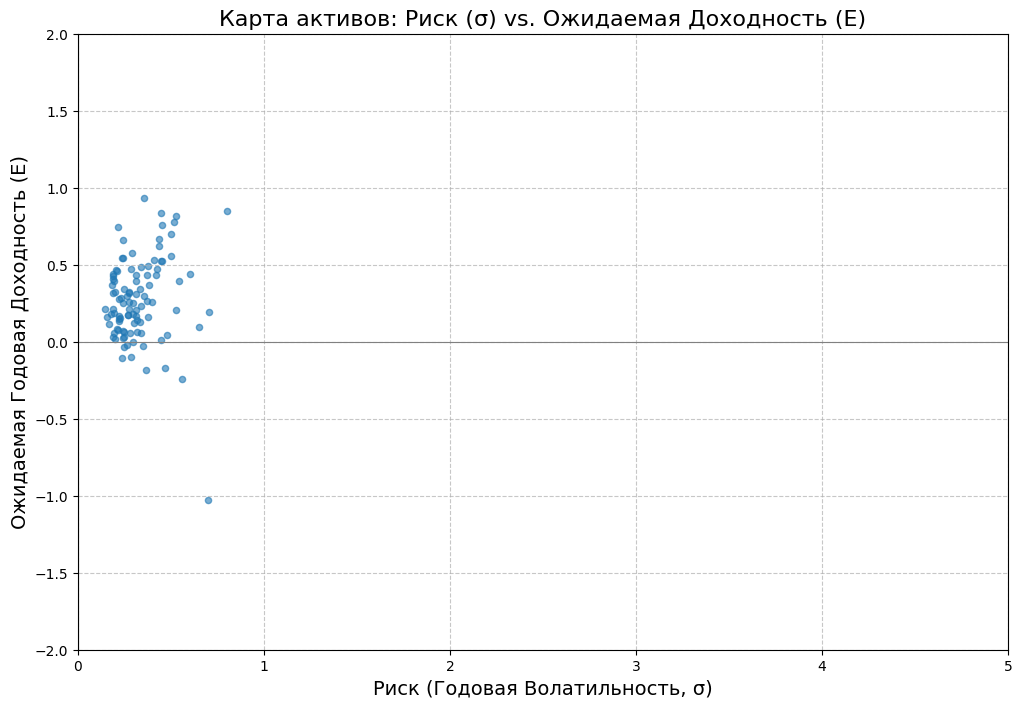

In [37]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.6,
    s=20
)

plt.title('Карта активов: Риск (σ) vs. Ожидаемая Доходность (E)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 5)
plt.ylim(-2, 2)

plt.axhline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевой доходности
plt.axvline(0, color='grey', linestyle='-', linewidth=0.8) # Линия нулевого риска

plt.show()

In [38]:
df = asset_metrics.reset_index().rename(columns={'index': 'Ticker'})
df_sorted = df.sort_values(by='Risk (sigma)', ascending=True).reset_index(drop=True)

pareto_assets = []
max_return_so_far = -np.inf

for index, row in df_sorted.iterrows():
    current_return = row['Expected Return (mu)']

    # Актив Парето-оптимален, если его доходность строго выше
    # максимальной доходности, достигнутой при меньшем риске.
    if current_return > max_return_so_far:
        pareto_assets.append(row['Ticker'])
        max_return_so_far = current_return

# 3. Фильтрация DataFrame по Парето-оптимальным активам
pareto_df = asset_metrics.loc[pareto_assets]

print(f"\nTotal number of Pareto-Optimal Assets found: {len(pareto_assets)}")
print("\n--- Pareto-Optimal Assets (E, σ) ---")
print(pareto_df.head(10))


Total number of Pareto-Optimal Assets found: 7

--- Pareto-Optimal Assets (E, σ) ---
       Expected Return (mu)  Risk (sigma)
PEP                0.211622      0.145204
EXC                0.365102      0.181067
ADP                0.404693      0.187943
PAYX               0.439326      0.188155
ORLY               0.468827      0.204702
CH10Y              0.742325      0.216287
FTNT               0.932563      0.352902


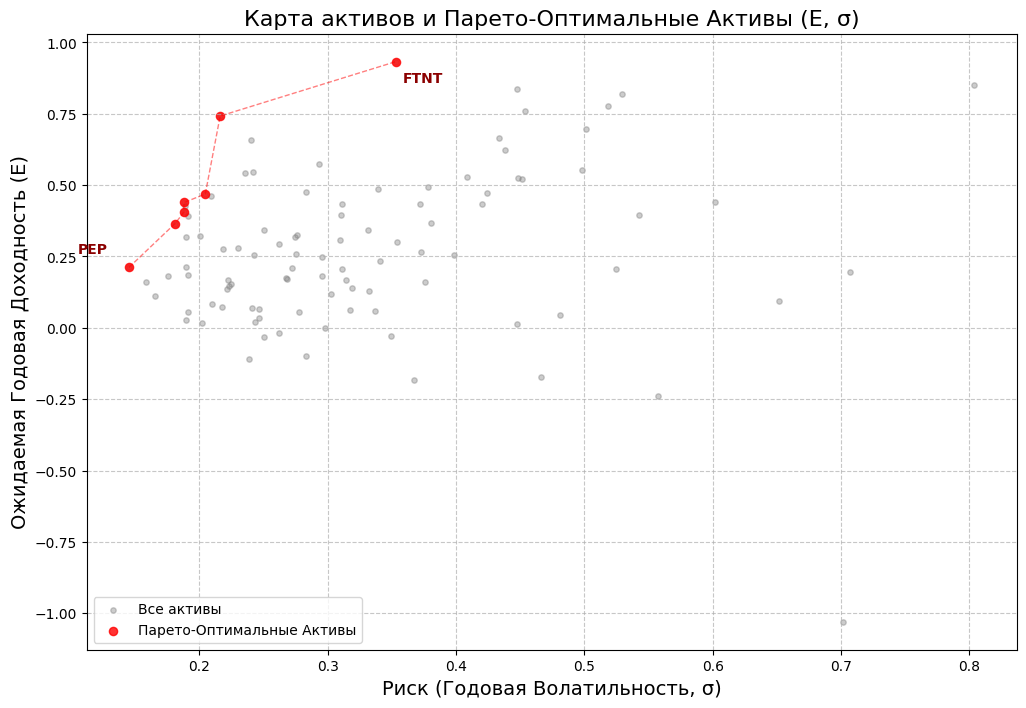

In [39]:
plt.figure(figsize=(12, 8))

plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

min_risk_asset = pareto_df.iloc[0]
max_return_asset = pareto_df.sort_values(by='Expected Return (mu)', ascending=False).iloc[0]

plt.annotate(
    min_risk_asset.name,
    (min_risk_asset['Risk (sigma)'], min_risk_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(-15, 10),
    ha='right',
    color='darkred',
    fontweight='bold'
)
plt.annotate(
    max_return_asset.name,
    (max_return_asset['Risk (sigma)'], max_return_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, -15),
    ha='left',
    color='darkred',
    fontweight='bold'
)


plt.title('Карта активов и Парето-Оптимальные Активы (E, σ)', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [40]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # Уровень значимости
PERCENTILE = ALPHA * 100 # перцентиль для поиска в распределении доходностей (5-й перцентиль)

pareto_log_returns = log_returns[pareto_assets]
var_daily_return = pareto_log_returns.quantile(ALPHA, axis=0)

# VaR - это ожидаемые потери (положительное число), поэтому берем отрицательное значение от доходности.
var_daily = -var_daily_return

# VaR_annual = VaR_daily * sqrt(T), как и стандартное отклонение
ANNUALIZATION_FACTOR = 252
var_annual = var_daily * np.sqrt(ANNUALIZATION_FACTOR)


# Объединяем VaR с метриками риска и доходности
pareto_df['VaR (Daily, 95%)'] = var_daily
pareto_df['VaR (Annual, 95%)'] = var_annual

pareto_df_sorted = pareto_df.sort_values(by='VaR (Annual, 95%)', ascending=True)

print(f"Calculated VaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual VaR ---")
print(pareto_df_sorted.head(10))

Calculated VaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual VaR ---
       Expected Return (mu)  Risk (sigma)  VaR (Daily, 95%)  VaR (Annual, 95%)
PEP                0.211622      0.145204          0.015773           0.250387
EXC                0.365102      0.181067          0.015817           0.251094
ORLY               0.468827      0.204702          0.016939           0.268891
PAYX               0.439326      0.188155          0.018438           0.292692
ADP                0.404693      0.187943          0.019289           0.306201
CH10Y              0.742325      0.216287          0.020502           0.325453
FTNT               0.932563      0.352902          0.035703           0.566766


In [41]:
# Наиболее предпочтительный актив по VaR - это актив с минимальным VaR.
# pareto_df_sorted уже отсортирован по возрастанию 'VaR (Annual, 95%)' (из cell 9),
# поэтому первый актив - наиболее предпочтительный.
most_preferred_asset = pareto_df_sorted.iloc[0]

ticker = most_preferred_asset.name
risk = most_preferred_asset['Risk (sigma)']
exp_return = most_preferred_asset['Expected Return (mu)']
daily_var = most_preferred_asset['VaR (Daily, 95%)']
annual_var = most_preferred_asset['VaR (Annual, 95%)']

print("--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---")
print(f"Тикер: {ticker}")
print(f"Годовой VaR (95%): {annual_var:.4f}")
print(f"Годовой Риск (σ): {risk:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return:.4f}")

# Для поиска на карте активов:
print("\nРасположение на карте (σ, E):")
print(f"Риск (X-координата): {risk:.4f}")
print(f"Доходность (Y-координата): {exp_return:.4f}")

--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ VaR ---
Тикер: PEP
Годовой VaR (95%): 0.2504
Годовой Риск (σ): 0.1452
Ожидаемая Годовая Доходность (E): 0.2116

Расположение на карте (σ, E):
Риск (X-координата): 0.1452
Доходность (Y-координата): 0.2116


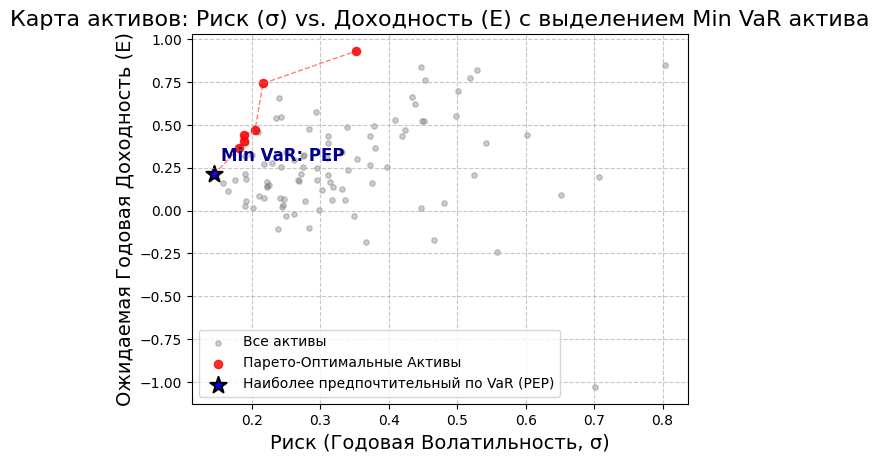

In [42]:
plt.scatter(
    asset_metrics['Risk (sigma)'],
    asset_metrics['Expected Return (mu)'],
    alpha=0.4,
    s=15,
    color='gray',
    label='Все активы'
)

plt.scatter(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    alpha=0.8,
    s=35,
    color='red',
    label='Парето-Оптимальные Активы'
)

plt.plot(
    pareto_df['Risk (sigma)'],
    pareto_df['Expected Return (mu)'],
    color='red',
    linestyle='--',
    linewidth=1,
    alpha=0.5
)

plt.scatter(
    most_preferred_asset['Risk (sigma)'],
    most_preferred_asset['Expected Return (mu)'],
    alpha=1.0,
    s=150,
    color='blue',
    marker='*',
    edgecolors='black',
    linewidths=1.5,
    label=f'Наиболее предпочтительный по VaR ({most_preferred_asset.name})'
)

plt.annotate(
    f'Min VaR: {most_preferred_asset.name}',
    (most_preferred_asset['Risk (sigma)'], most_preferred_asset['Expected Return (mu)']),
    textcoords="offset points",
    xytext=(5, 10),
    ha='left',
    color='darkblue',
    fontweight='bold',
    fontsize=12
)


plt.title('Карта активов: Риск (σ) vs. Доходность (E) с выделением Min VaR актива', fontsize=16)
plt.xlabel('Риск (Годовая Волатильность, σ)', fontsize=14)
plt.ylabel('Ожидаемая Годовая Доходность (E)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [43]:
CONFIDENCE_LEVEL = 0.95
ALPHA = 1 - CONFIDENCE_LEVEL # 0.05

pareto_log_returns = log_returns[pareto_assets]

# 2. Находим пороговое значение доходности (5-й перцентиль)
var_threshold = pareto_log_returns.quantile(ALPHA, axis=0)

# 3. Рассчитываем CVaR (Average of returns <= threshold)
cvar_daily = {}
for ticker in pareto_log_returns.columns:
    tail_returns = pareto_log_returns[ticker][pareto_log_returns[ticker] <= var_threshold[ticker]]

    # CVaR = - Среднее значение этих хвостов
    cvar_daily[ticker] = -tail_returns.mean()

cvar_daily_series = pd.Series(cvar_daily)

ANNUALIZATION_FACTOR = 252 # возьмём за год
cvar_annual_series = cvar_daily_series * np.sqrt(ANNUALIZATION_FACTOR)

pareto_df['CVaR (Daily, 95%)'] = cvar_daily_series
pareto_df['CVaR (Annual, 95%)'] = cvar_annual_series

pareto_df_cvar_sorted = pareto_df.sort_values(by='CVaR (Annual, 95%)', ascending=True)

print(f"Calculated CVaR at {CONFIDENCE_LEVEL * 100:.0f}% confidence level.")
print("\n--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---")
print(pareto_df_cvar_sorted[['Expected Return (mu)', 'Risk (sigma)', 'VaR (Annual, 95%)', 'CVaR (Annual, 95%)']].head(10))

Calculated CVaR at 95% confidence level.

--- Pareto-Optimal Assets sorted by Annual CVaR (Top 10) ---
       Expected Return (mu)  Risk (sigma)  VaR (Annual, 95%)  \
PEP                0.211622      0.145204           0.250387   
PAYX               0.439326      0.188155           0.292692   
ADP                0.404693      0.187943           0.306201   
EXC                0.365102      0.181067           0.251094   
ORLY               0.468827      0.204702           0.268891   
CH10Y              0.742325      0.216287           0.325453   
FTNT               0.932563      0.352902           0.566766   

       CVaR (Annual, 95%)  
PEP              0.315924  
PAYX             0.388915  
ADP              0.401941  
EXC              0.417573  
ORLY             0.460438  
CH10Y            0.465842  
FTNT             0.723307  


In [44]:
# Наиболее предпочтительный актив по CVaR - это актив с минимальным CVaR (первый в отсортированном df)
most_preferred_asset_cvar = pareto_df_cvar_sorted.iloc[0]

ticker_cvar = most_preferred_asset_cvar.name
risk_cvar = most_preferred_asset_cvar['Risk (sigma)']
exp_return_cvar = most_preferred_asset_cvar['Expected Return (mu)']
annual_cvar = most_preferred_asset_cvar['CVaR (Annual, 95%)']

print("\n--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---")
print(f"Тикер: {ticker_cvar}")
print(f"Годовой CVaR (95%): {annual_cvar:.4f}")
print(f"Годовой Риск (σ): {risk_cvar:.4f}")
print(f"Ожидаемая Годовая Доходность (E): {exp_return_cvar:.4f}")

# Для сравнения с VaR:
most_preferred_asset_var = pareto_df_sorted.iloc[0]

print("\n--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---")
print(f"Тикер, предпочтительный по VaR: {most_preferred_asset_var.name}")
print(f"Тикер, предпочтительный по CVaR: {ticker_cvar}")

if ticker_cvar == most_preferred_asset_var.name:
    print("Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.")
else:
    print("Вывод: Активы, минимизирующие VaR и CVaR, различаются. Это означает, что актив, минимизирующий CVaR, имеет более тонкий 'хвост' (меньше экстремальных потерь) по сравнению с активом, минимизирующим VaR.")


--- АКТИВ, НАИБОЛЕЕ ПРЕДПОЧТИТЕЛЬНЫЙ ПО ХАРАКТЕРИСТИКЕ CVaR ---
Тикер: PEP
Годовой CVaR (95%): 0.3159
Годовой Риск (σ): 0.1452
Ожидаемая Годовая Доходность (E): 0.2116

--- СРАВНЕНИЕ С РЕЗУЛЬТАТОМ ПО VaR ---
Тикер, предпочтительный по VaR: PEP
Тикер, предпочтительный по CVaR: PEP
Вывод: Активы, минимизирующие VaR и CVaR, совпадают. Это ожидаемо, поскольку они оба направлены на минимизацию левого хвоста распределения. Этот актив расположен в самой левой (наименее рискованной) части Парето-границы.
